### Notebook Preliminaries 

Make equation numbers work in Latex markdown.

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Register.StartupHook("TeX AMSmath Ready", function () {
  var AMS = MathJax.Extension['TeX/AMSmath'];
  MathJax.InputJax.TeX.postfilterHooks.Add(function (data) {
    var jax = data.script.MathJax;
    jax.startNumber = AMS.startNumber;
    jax.eqLabels = AMS.eqlabels;
    jax.eqIDs = AMS.eqIDs;
  });
  MathJax.InputJax.TeX.prefilterHooks.Add(function (data) {
    var jax = data.script.MathJax;
    if (jax.startNumber != undefined) {
      AMS.startNumber = jax.startNumber;
      Object.keys(jax.eqLabels).forEach(function (x) {delete AMS.labels[x]});
      Object.keys(jax.eqIDs).forEach(function (x) {delete AMS.IDs[x]});
    }
  }, 1);
});

<IPython.core.display.Javascript object>

## Algorithm

#### Global constants across different experiments

- Minimum frequency to measure: 60Hz
- Hop: 0.01s between measurements
- Maximum frequency: a default value when the algorithm gets confused
- Minimum singing sound volume: 0.05

In [2]:
from os.path import isfile

# Format of Collection/Song/minmax file:
# 1  minf0_v1  maxf0_v1
# 2  minf0_v2  maxf0_v2
# 3  minf0_v3  maxf0_v3

def minmax_f0(file, voice):
    if (os.path.isfile(file)):
        for line in file:
            v, minf0, maxf0 = line.split()
            if v == voice:
                return (minf0, maxf0)
    return (60, 2000)
    
def min_f0():
    return 60

def hop_ms():
    return 10

def max_f0():
    return 2000

def min_singing_volume():
    return 0.05


### Main steps

The Yin algorithm works in the "time domain", i.e., the original audio.

- Use the method in the [paper of Cheveigne and Kawahara](https://drive.google.com/file/d/1cM4ZEY6c0F0mZnEkXlizblVEVtM7HtJ6/view?usp=sharing) to detect the (one) fundamental frequency of the voice in the audio
    - Step 1. Simple autocorrelation.
    - Step 2. Difference function.
    - Step 3. Cumulative mean of difference function (CMDF): makes the minimum clearer (removes need for a min period)
    - Step 4. Absolute threshold: a threshold for a local min of the CMDF to qualify as a period estimate
    - Step 5. Parabolic fit: to find the precise location and value of a local minimum
    - Step 6. Best local estimate: compare neighboring estimates to overcome effects of phase

### Notes

Notes on development.

- 7/23/20 
    - Finished implementing Yin. The algorithm mistakenly estimates f0 an octave high in seconds 5-6 and 14-15 of the 2nd voice throat mic of Batonebis Nanina. 
    - I downloaded [Patrice Guyot's Yin implementation](https://github.com/patriceguyot/Yin), which skips steps of the algorithm and does no better in these sections. 
    - I downloaded the Vamp plugin package for Sonic Visualizer, including Queen's University's Yin and [pYin](https://code.soundsoftware.ac.uk/projects/pyin) implementations. With Yin, Sonic Visualizer's pitches looked the same as my implementation's. With pYin it was much worse, regularly choosing the octave higher.

- 8/5/20
    - Mauch's pYin implementation does not use Step 6. My Step 6 didn't help.
    - What helped was applying a rectangular 1ms filter as a preprocessor.
    - I need to make Steps 1-5 the default.

### Step 1. Simple autocorrelation

The most basic formula for autocorrelation is

\begin{equation}
r_t(\tau) = \sum^{t+W-1}_{j=t} x_j x_{j+\tau}
\end{equation}

(The paper takes $j$ from $t+1$ to $t+W$.)

<font color="blue">To implement this for $j>t+W-\tau$ we'll get samples from the signal outside the window. We could extend the signal outside the window so that it is periodic with period $W$, but that seems more likely to pick up artifacts. The paper is ambiguous, because in Fig. 1(a) the window seems to be a multiple of the period of the signal. </font>

The usual definition of autocorrelation is

\begin{equation}
r'_t(\tau) = \sum^{t+W-1-\tau}_{j=t} x_j x_{j+\tau}
\end{equation}

This is the same as Equation (1) if we pad the signal with zeroes outside the window. It has the effect of making $r'_t(\tau)$ smaller as $\tau$ increases.

The paper simulates this effect by multiplying $r_t(\tau)$ by ramps of of different slopes and empirically finding the slope that gives the lowest pitch estimate error on a dataset:

\begin{equation}
r''_t(\tau) = r_t(\tau) (1 - \tau/\tau_{max})
\end{equation}
if $\tau < \tau_{max}$, and $r''_t(\tau) = 0$ otherwise.

The optimal value was $\tau \approx 35$ms, which means that only frequencies above $\sim 30$Hz were measurable and only frequencies above $\sim 90$Hz were important (since it takes 3 waves to measure a frequency accurately). Picking $\tau < 35$ms would make it hard to measure frequencies in the speech range. It's not intuitively clear what's wrong with picking $\tau > 35$ms; maybe the assumption of periodicity is false for the samples of speech in the dataset.

#### Brute-force computation of the autocorrelation function at every sample point is too slow. 

Let's use the recursion

\begin{equation}
r_t(\tau) = r_{t-1}(\tau) + x_{t+W-1} x_{t+W+\tau-1} - x_{t-1} x_{t+\tau-1}
\end{equation}

to fill the 1D array $\{r(t, \tau): \tau = 0, 1, \ldots, \tau_{max}\}$, for each $t = 0, 1, \ldots$. 

If we're using wraparound (turned off by default):
- the first term, $x_{t+W} x_{t+W+\tau}$, wraps around (relative to $t+1$) to $x_{t+W} x_{t+\tau}$ for $\tau>0$.
- the second term, $x_{t} x_{t+\tau}$, doesn't wrap around (relative to $t$) as long as $\tau < W$.

#### Define helper functions and a function to calculate f0 at equally spaced sample points in an audio file

In [3]:
import scipy.signal as ss
import scipy.fft
import librosa
import numpy as np
import matplotlib.pyplot as plt

# initial low-pass filter
def lowpass_filter(y):
    return ss.convolve(y, np.ones(48), mode='same', method='auto')

# autocorrelation function - Eqn (1) above - using recursion (4) above
#  - creates/updates the array {r_t(tau): tau = 0, 1, ..., W}
#  - returns:
#    - if acf = None: returns the array {r_0(tau): tau = 0, 1, ..., W}
#    - if acf != None: returns None
#  - y is a sequence of audio samples
#  - creates 
#  - the function operates on the subsequence y[t+1:t+W], with wraparound if wrap=true
def acf1_from_scratch(y, W, t=0):
    return np.correlate(y[t:t+2*W-1], y[t:t+W])
    
#
# - Does something only if acf.size >= W and t>0
def acf1_incremental(y, W, t, acf):
    if t <= 0 or acf.size < W:
        return None
    try:
        return acf + y[t+W-1]*y[t+W-1:t+2*W-1] - y[t-1]*y[t-1:t+W-1]
    except ValueError:
        print(acf.size, t, W, y.size)
            
# returns a ramp used to dampen the autocorrelation function
def get_ramp(tau_max):
    return 1-np.array(range(tau_max,))/tau_max

# This relationship is from the paper.
# This is ok even if later we specify our own minf0.
def W_ms():
    return 1000//min_f0()

# This relationship is from the paper.
def W_ms(file=None, voice=None):
    if file != None:
        return 1000//minmax_f0(file, voice)[0]
    else:
        return 1000//min_f0()

# returns a batch of autocorrelation functions indexed by (t, tau)
def get_acf_in_range(y, W, start, end):
    acf = np.ndarray((end-start, W))
    
    for t in range(start, end): 
        if t==start:
            acf[t-start,:] = acf1_from_scratch(y, W, t)
        else:
            acf[t-start,:] = acf1_incremental(y, W, t, acf[t-start-1,:])
            
    return acf

# finds f0 from an autocorrelation function
# - for now, finds the second strongest wavelength of the acf, after 0:
#   - Assume f0<min_f0, so wavelength >sr/min_f0
#   - Find argmax(smooth_acf(tau)), tau > sr/min_f0
# - acf: a list of acf(tau) for tau = 0,..., W-1
def get_f0(acf, sr):
    return sr//(sr//max_f0() + np.argmax(acf[sr//max_f0():]))

### Step 2. Difference function

The "signal model" for a periodic signal of period $T$

\begin{equation}
x_t - x_{t+T} = 0,~\forall T
\end{equation}

suggests minimizing the sum of squares of differences 

\begin{align}
d_t(\tau) & = \sum^{t+W-1}_{j=t} (x_j - x_{j+\tau})^2 \\
          & = r_t(0) + r_{t+\tau}(0) - 2r_t(\tau)
\end{align}

It turns out $r_t(\tau)$ is sensitive to changes in amplitude and $d_t(\tau)$ isn't.

#### Note

We need only compute $d_t(\tau)$ for $t = $ a multiple of `hop_ms()`, or every $sr/100$ samples.


### Step 3. Difference function normalized by the mean so far

The normalized difference function is

\begin{equation}
d'_t(\tau) = 
\begin{cases}
1, & \text{if $\tau=0$} \\
d_t(\tau) \bigg/ \frac{\sum^{\tau}_{j=1} d_t(j)}{\tau}, & \text{otherwise}
\end{cases}
\end{equation}


### Step 4. Threshold for minimum of difference function

Choose the smallest local minimum value of $d'$ below a threshold.

The paper chooses a threshold of $0.1$.

I've modified that to a threshold of $min(0.1,2*{\text global min})$ because the Yin algorithm picks up higher frequencies from the larynx mic during a glissando.


In [4]:
def diff_function(r, times):
    W = r.shape[1]
    T = r.shape[0]
    d = np.zeros((times.size, W))
    i = 0
    for t in times:
        d[i,:] = r[t,0] + r[t:t+W,0] - 2*r[t,:]
        i += 1
    return d    

# fancier but covers any errors
def fancy_normalize_diff(d):
    with np.errstate(divide='ignore', invalid='ignore'):
        normd = np.true_divide(d*np.arange(W), np.cumsum(d, axis=1))
        normd[ ~ np.isfinite( normd )] = 1  # -inf inf NaN
    return normd

# fast enough?
def normalize_diff(d):
    W = d.shape[1]
    csum = np.cumsum(d, axis=1)
    csum[:,0] = 1
    normd = np.true_divide(d*np.arange(1,W+1), csum)
    normd[:,0] = 1 
    return normd

def tau_min_threshold():
    return 0.1

def tau_min_mult_threshold():
    return 2

# finds f0 from a "difference autocorrelation function"
# - for now, finds the first "low" local minimum in the normalized difference function of the acf:
# - d: a list of d(tau) for tau = 0,..., W-1
def get_f0(d, sr):
    tau_min = np.argmin(d[:])
    d_thresh = np.argmax(d<tau_min_threshold())
    return sr/(d_thresh if d[d_thresh]<min(tau_min_threshold(),tau_min_mult_threshold*tau_min) else tau_min)
    

### Step 5. Fit a parabola to each local minimum of $d'$

Find either
- the smallest index $\tau$ of a local minimum whose fitted parabola takes values smaller than $0.1$, if such a local minimum exists
- the index $\tau$ of the global minimum of $d'$ (the local minimum whose fitted parabola takes the lowest value)

The abscissa of the minimum of the fitted parabola is biased because of the normalization of $d'$:
- the index of a local minimum of $d'$ is less than or equal to the index of the corresponding local minimum of $d$, but in a pathological (and possibly unrealistic) case it can much smaller
- simple math shows it can't be bigger

Given the $\tau'$ of the best local minimum of $d'$:
- search for $\tau>\tau'$ of the corresponding local minimum of $d$
- fit $d(\tau)$ locally to a parabola and return the abscissa of the minimum value of the parabola

The parabola $ax^2 + bx + c$ goes through the points $(-1, x)$, $(0, c)$, and $(1, y)$, where $x = a-b+c$ and  and $y = a+b+c$, and reaches its minimum at 
$$\tau = \frac{x-y}{2*(x+y-2c)}.$$ 
The minimum value is
$$-\frac{b^2}{4a} + c = -\frac{(x-y)^2}{8(x+y-2c)} + c.$$

#### The Code for Steps 1-6 is at the bottom of the notebook.

Step 6 was hard to develop, made the process run slower, and didn't seem to improve accuracy.

What follows are steps 1-5.

In [5]:
## These functions return arrays with indices 0 to W-1 representing tau = 0 to W-1 

# the argmins of the parabolas through each group of three consecutive points in the array
def quadratic_argmins(a):
    W = a.size
    argmins = np.r_[0, np.true_divide(a[:-2]-a[2:],a[:-2]+a[2:]-2*a[1:-1])/(2) + np.arange(1,a.size-1), W-1]
    return argmins

# the mins of the parabolas through each group of three consecutive points in the array
def quadratic_mins(a):
    return np.r_[1, -np.true_divide((a[:-2]-a[2:])**2,8*(a[:-2]+a[2:]-2*a[1:-1])) + a[1:-1], 1]

def local_mins(a):
    #return np.r_[False,a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:],False]
    return np.r_[False, (a[1:-1] < a[:-2]) & (a[1:-1] <= a[2:]), False]

# finds the best index from normd and uses it to find the best abscissa from d 
def get_period(y_window, normd, d, minPeriod=0, maxPeriod=None):
    if max(y_window) < min_singing_volume():
        return 0
    qnormd = quadratic_mins(normd)
    qnormd[~local_mins(normd)] = 1
    
    if maxPeriod == None:
        maxPeriod = qnormd.size
    else:
        maxPeriod = min(maxPeriod+1, qnormd.size)
    
    # smallest local min tau whose parabola goes under 0.1
    # argmax of Trues and Falses finds the first True
    tau_min = minPeriod + np.argmax(qnormd[minPeriod:maxPeriod]<tau_min_threshold()) 
    
    if qnormd[tau_min] >= tau_min_threshold():  
        tau_min = minPeriod + np.argmin(qnormd[minPeriod:maxPeriod])

    # cases:
    # - qnormd[tau_min] < 1 because it's a local minimum or minimum at minPeriod or maxPeriod 
    # - tau_min = first non-local-min >= minPeriod, because there is no value < 1            

    # a local min of normd must occur at or earlier than the corresponding local min of d
    #! this should be vectorized
    for i in range(tau_min, d.size-1):
        if d[i+1] > d[i]:
            break
    return quadratic_argmins(d)[i] 

In [6]:
# reff0 will be used to constrain the range of periods yin searches in

def yin1To5(y, sr, minf0, maxf0):
    # initialize variables
    # W, start, end, last_t are multiples of hop
    hop = hop_ms()*sr//1000 # assume there's no rounding
    W = W_ms() * sr // 1000
    W = W + hop - W%hop
    
    start = 0
    batch_size = hop*100
    end = min(y.size-2*W, start + batch_size)
    end = end - end%hop
    last_t = end-W
    batches = 200
    f0_arr = np.ndarray(max(0,min(y.size,batches*batch_size-W)//hop))
    
    # range of periods to search
    minPeriod = sr//maxf0;
    maxPeriod = (sr+minf0-1)//minf0;

    for b in range(batches):
        print("Batch " + str(b) + " from t=" + str(start) + " to " + str(end))
        # Compute autocorrelation and difference functions for a range of t 
        acf1=get_acf_in_range(y, W, start, end)
        diff_times = np.arange(0,last_t-start,hop)
        d = diff_function(acf1, diff_times)        
        normd = normalize_diff(d)

        # Get f0 values
        for i in range(diff_times.size):
            t = diff_times[i]+start
            #print("Time " + str())
            est_period = get_period(y[t:t+W], normd[i,:], d[i,:], minPeriod, maxPeriod)
            if est_period*max_f0() < sr:
                f0_arr[i+(start//hop)] = 0
            else:
                f0_arr[i+(start//hop)] = sr/est_period

        if end == y.size-2*W:
            break
        start = end-W
        end = min(y.size-2*W, end + batch_size)
        last_t = end-W
        
    return f0_arr

### Postprocessing

1. A simple step to correct the pitch when Yin picks 2f0, f0/2, or f0/3.
2. Force correction if the pitch is outside the main octave.

Fix the file in place and remove the backup except in debug mode.

In [7]:
from os import rename, remove
from os.path import join, splitext
from queue import Queue

qSize=10
numQs = 3
variance_tolerance = 100
octaveRange = 1.0
binsPerOctave = 12
rangeInBins = int(octaveRange*binsPerOctave)
minTessitura=64
maxTessitura=1024
octaves=4

def rolling_window_1d(a, window, hop):
    shape = ((a.shape[0] - window + hop)//hop, window)
    strides = (a.strides[0]*hop, a.strides[0])
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def prevf(f, idx):
    qs = rolling_window_1d(f[idx-qSize*numQs:idx], qSize, qSize)
    means = np.mean(qs, axis=1)
    variances = np.var(qs, axis=1)
    retval = f[idx]
    if np.min(variances) < variance_tolerance:
        retval = means[np.argmin(variances)]
    return retval

def isClose(prevf, f, minf0):
    tolerance = 0.1
    if prevf <= minf0:
        return False
    if abs((f-prevf)/prevf) < 0.1:
        return True
    return False

def f0range(hist, binEdges):
    integral = np.sum(hist[:rangeInBins])
    maxIntegral = integral
    imax=0
    i = 1
    while i < hist.size-rangeInBins:
        integral += hist[i+rangeInBins] - hist[i-1]
        if integral > maxIntegral:
            maxIntegral = integral
            imax = i
        i += 1
    return (binEdges[imax], binEdges[imax+rangeInBins])

def getF0Range(rawfile, debug=False):
    t, f0Est = np.loadtxt(rawfile, unpack=True)
    
    # histogram of f0 estimates
    maxf0Est = np.max(f0Est)
    binEdges = np.rint(np.geomspace(minTessitura, maxTessitura, num=binsPerOctave*octaves+1)).astype(int)
    f0RawHist, bin_edges  = np.histogram(f0Est, bins=binEdges, range=(0, maxf0Est))
    return f0range(f0RawHist, binEdges)
    
def postprocess(file, debug=False):
    rawfile = splitext(file)[0] + '.raw.txt'
    rename(file, rawfile)
    t, f0Est = np.loadtxt(rawfile, unpack=True)
    
    # adjust to closest pitch in range
    idx = numQs*qSize
    for i in range(idx, f0Est.size):
        if i%48000 == 0:
            print(i)
        prev = prevf(f0Est, i)
        f = f0Est[i]
        if isClose(prev, f/2, minf0):
            f0Est[i] = f/2
        elif isClose(prev, 2*f, minf0):
            f0Est[i] = 2*f
        elif isClose(prev, 3*f, minf0):
            f0Est[i] = 3*f

    np.savetxt(file, np.column_stack((t, f0Est)), fmt='%6.2f %7.2f')
    f0Hist = np.histogram(f0Est, bins=200, range=(0, maxf0Est))[0]
    if debug:
        print("Saving un-postprocessed file:\n" + rawfile)
        print("Plotting before/after histograms")
        plt.plot(np.arange(0, maxf0Est, maxf0Est/200.), f0RawHist, '.')
        plt.plot(np.arange(0, maxf0Est, maxf0Est/200.), f0Hist, '.')
        plt.show()
    else:
        os.remove(rawfile)
    
### Testing ###
test=False
if test:
    file = join('/Akamai/voice/data/', 'pitches/yin','Scherbaum Mshavanadze/')
    file = join(file, 'GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919')
    file = join(file, 'GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_AHDS1M.txt')
    postprocess(file, min_f0(), max_f0(), True)
    
    rawfile = splitext(file)[0] + '.raw.txt'
    t, f0 = np.loadtxt(file, unpack=True)
    t, f0raw = np.loadtxt(rawfile, unpack=True)
    plt.rcParams['figure.figsize'] = [100, 5]
    plt.plot(t,f0,'.')
    plt.plot(t,f0raw,'.')
    plt.show()

## Get Data.

#### Create an html parser to read the directory manifest

In [8]:
from html.parser import HTMLParser
from os.path import basename

new_track = False
class MyHTMLParser(HTMLParser):
    def __init__ (self):
        HTMLParser.__init__(self)
        self.data = []

    def handle_starttag(self, tag, attrs):
        new_track = True
        if tag == "track-wrap":
            for key, val in attrs:
                if key == "title":
                    self.data.append(val)
        if tag == "video":
            self.data.append("video")
        if tag == "source":
            for key, val in attrs:
                if key == "src":
                    self.data.append(basename(val))

    def handle_endtag(self, tag):
        if tag == "track-wrap" or tag == "video":
            new_track = False

    def handle_data(self, data):
        pass
    
    def get_data (self):
        return zip(self.data, self.data[1:] + self.data[:1])



### Get all the files in one Collection/Song directory.

In [9]:
import re
from os import listdir
from os.path import isdir, join, splitext, exists, dirname

def getFiles(coll, sd, debug=0):
    files = dict()
    if coll == "Scherbaum Mshavanadze":
        html= open(join(root, coll, sd, 'page.txt')).read()
        parser = MyHTMLParser()
        parser.feed(html)
        files['throat'] = [f[1] for f in \
                           list(filter(lambda x: re.search("Throat microphone [0-9]+", x[0]), parser.get_data()))]
        files['headset'] = [f[1] for f in \
                            list(filter(lambda x: re.search("Headset microphone [0-9]+", x[0]), parser.get_data()))]
    else:
        suffixes = dict()
        suffixes["Teach Yourself Megrelian Songs"] = [" (bass)", " (middle)", " (top)"]
        suffixes["Teach Yourself Gurian Songs"] = [" - bass", " - middle", " - top"]
        files['headset'] = [sd + suff + ".mp3" for suff in suffixes[coll]]

        if coll == "Teach Yourself Megrelian Songs":
            sd = "mp3"
        

    return (sd, files)
    
def replaceVoice(name):
    voice = dict()
    voice["(bass)"] = (7," AHDS1M")
    voice["- bass"] = (7," AHDS1M")
    voice["iddle)"] = (9," AHDS2M")
    voice["middle"] = (9," AHDS2M")
    voice[" (top)"] = (6," AHDS3M")
    voice[" - top"] = (6," AHDS3M")
    if name[-6:] in voice:
        (sufflen, new_suff) = voice[name[-6:]]
        return name[:len(name)-sufflen] + new_suff
    else:
        return name
   

#### Run the Yin algorithm on 'throat' and 'headset' files in all song directories.

Scherbaum Mshavanadze ,  GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919
GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919 ,  {'throat': ['GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_ALRX1M.wav', 'GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_ALRX2M.wav', 'GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_ALRX3M.wav'], 'headset': ['GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_AHDS1M.wav', 'GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_AHDS2M.wav', 'GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_AHDS3M.wav']}
Skipping final estimate, file already exists:  /Akamai/voice/data/pitches/yin/Scherbaum Mshavanadze/GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919/GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_ALRX1M.txt
Skipping final estimate, file already exists:  /Akamai/voice/data/pitches/yin/Scherbaum Mshavanadze/GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919/GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_ALRX2M.txt
Skipping final estimate, file already exists:  /Akam

Teach Yourself Gurian Songs ,  Adila-Alipasha
Adila-Alipasha ,  {'headset': ['Adila-Alipasha - bass.mp3', 'Adila-Alipasha - middle.mp3', 'Adila-Alipasha - top.mp3']}
Skipping final estimate, file already exists:  /Akamai/voice/data/pitches/yin/Teach Yourself Gurian Songs/Adila-Alipasha/Adila-Alipasha AHDS1M.txt
Skipping final estimate, file already exists:  /Akamai/voice/data/pitches/yin/Teach Yourself Gurian Songs/Adila-Alipasha/Adila-Alipasha AHDS2M.txt
Skipping final estimate, file already exists:  /Akamai/voice/data/pitches/yin/Teach Yourself Gurian Songs/Adila-Alipasha/Adila-Alipasha AHDS3M.txt
Teach Yourself Gurian Songs ,  Alaverdi
Alaverdi ,  {'headset': ['Alaverdi - bass.mp3', 'Alaverdi - middle.mp3', 'Alaverdi - top.mp3']}
Skipping final estimate, file already exists:  /Akamai/voice/data/pitches/yin/Teach Yourself Gurian Songs/Alaverdi/Alaverdi AHDS1M.txt
Skipping final estimate, file already exists:  /Akamai/voice/data/pitches/yin/Teach Yourself Gurian Songs/Alaverdi/Alaverd

Skipping final estimate, file already exists:  /Akamai/voice/data/pitches/yin/Teach Yourself Gurian Songs/Orira/Orira AHDS1M.txt
Skipping final estimate, file already exists:  /Akamai/voice/data/pitches/yin/Teach Yourself Gurian Songs/Orira/Orira AHDS2M.txt
Skipping final estimate, file already exists:  /Akamai/voice/data/pitches/yin/Teach Yourself Gurian Songs/Orira/Orira AHDS3M.txt
Teach Yourself Gurian Songs ,  P'at'ara Saq'varelo
P'at'ara Saq'varelo ,  {'headset': ["P'at'ara Saq'varelo - bass.mp3", "P'at'ara Saq'varelo - middle.mp3", "P'at'ara Saq'varelo - top.mp3"]}
Skipping final estimate, file already exists:  /Akamai/voice/data/pitches/yin/Teach Yourself Gurian Songs/P'at'ara Saq'varelo/P'at'ara Saq'varelo AHDS1M.txt
Skipping final estimate, file already exists:  /Akamai/voice/data/pitches/yin/Teach Yourself Gurian Songs/P'at'ara Saq'varelo/P'at'ara Saq'varelo AHDS2M.txt
Skipping final estimate, file already exists:  /Akamai/voice/data/pitches/yin/Teach Yourself Gurian Songs/P'

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Skipping raw estimate, raw file already exists:  /Akamai/voice/data/pitches-raw/yin/Teach Yourself Gurian Songs/Sabodisho/Sabodisho AHDS3M.txt
Voice range:  171 342
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

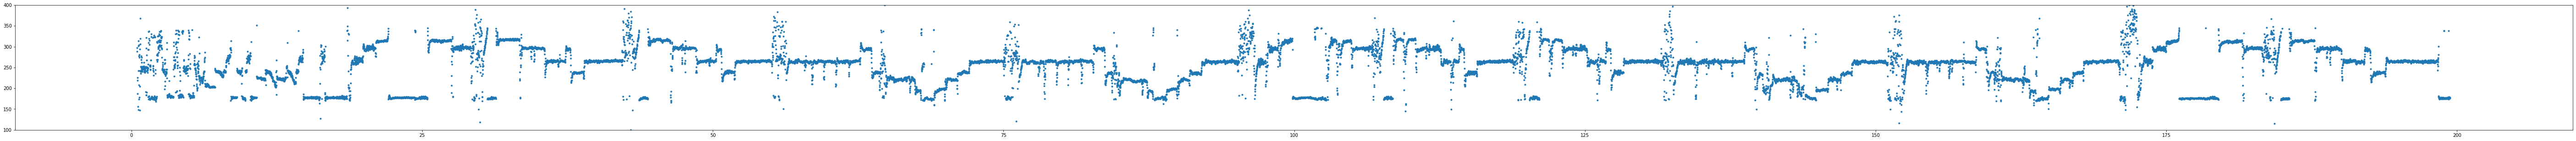

Teach Yourself Gurian Songs ,  Sadats Vshobilvar
Sadats Vshobilvar ,  {'headset': ['Sadats Vshobilvar - bass.mp3', 'Sadats Vshobilvar - middle.mp3', 'Sadats Vshobilvar - top.mp3']}


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Sadats Vshobilvar - bass.mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Batch 122 from t=5379318 to 5424300
Batch 123 from t=5423418 to 5443740
Yin raw f0 estimates written to:  /Akamai/voice/data/pitches-raw/yin/Teach Yourself Gurian Songs/Sadats Vshobilvar/Sadats Vshobilvar AHDS1M.txt
Voice range:  128 256
Batch 0 from t=0 to 44100
Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=10134

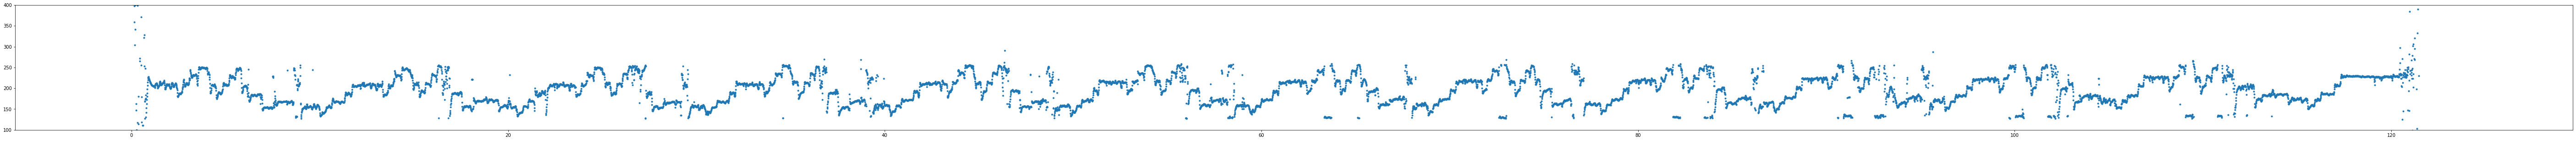

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Sadats Vshobilvar - middle.mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 110 from t=4850118 to 4895100
Batch 111 from t=4894218 to 4939200
Batch 112 from t=4938318 to 4983300
Batch 113 from t=4982418 to 5027400
Batch 114 from t=5026518 to 5071500
Batch 115 from t=5070618 to 5115600
Batch 116 from t=5114718 to 5159700
Batch 117 from t=5158818 to 5203800
Batch 118 from t=5202918 to 5247900
Batch 119 from t=5247018 to 5292000
Batch 120 from t=5291118 to 5336100
Batch 121 from t=5335218 to 5380200
Batch 122 from t=5379318 to 5402268
Yin final f0 estimates written to:  /Akamai/voice/data/pitches/yin/Teach Yourself Gurian Songs/Sadats Vshobilvar/Sadats Vshobilvar AHDS2M.txt


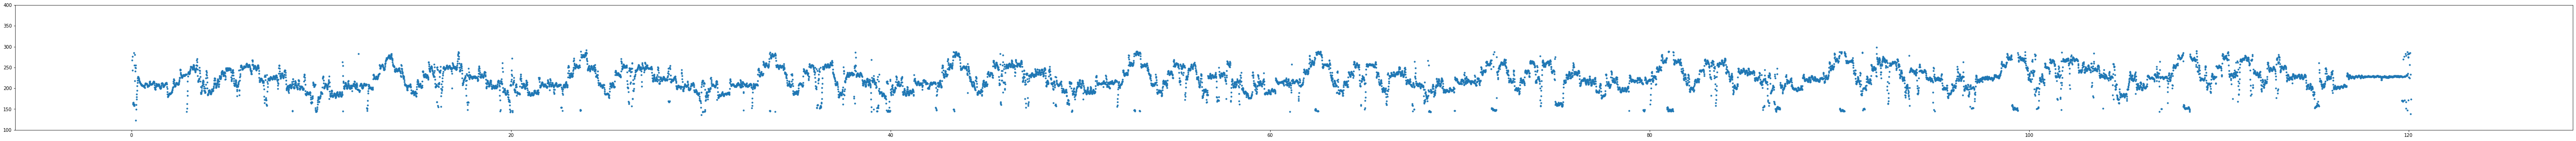

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Sadats Vshobilvar - top.mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 109 from t=4806018 to 4851000
Batch 110 from t=4850118 to 4895100
Batch 111 from t=4894218 to 4939200
Batch 112 from t=4938318 to 4983300
Batch 113 from t=4982418 to 5027400
Batch 114 from t=5026518 to 5071500
Batch 115 from t=5070618 to 5115600
Batch 116 from t=5114718 to 5159700
Batch 117 from t=5158818 to 5203800
Batch 118 from t=5202918 to 5247900
Batch 119 from t=5247018 to 5292000
Batch 120 from t=5291118 to 5336100
Batch 121 from t=5335218 to 5380200
Batch 122 from t=5379318 to 5424300
Batch 123 from t=5423418 to 5429916
Yin final f0 estimates written to:  /Akamai/voice/data/pitches/yin/Teach Yourself Gurian Songs/Sadats Vshobilvar/Sadats Vshobilvar AHDS3M.txt


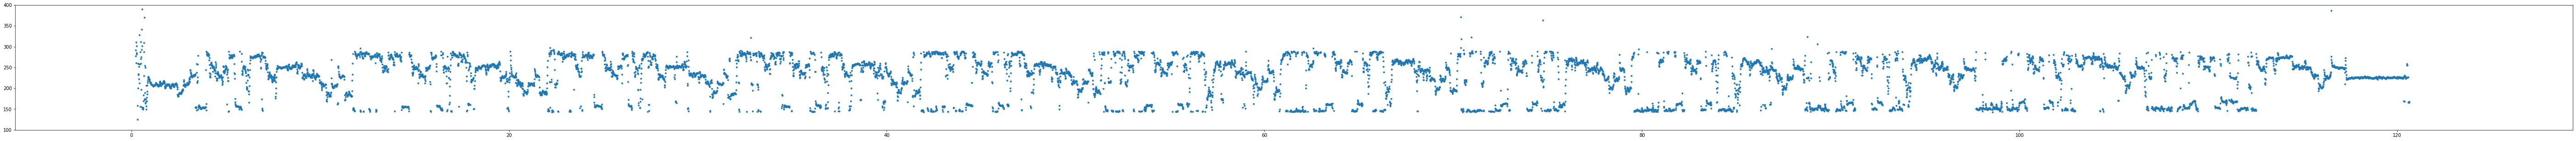

Teach Yourself Gurian Songs ,  Shermanduli
Shermanduli ,  {'headset': ['Shermanduli - bass.mp3', 'Shermanduli - middle.mp3', 'Shermanduli - top.mp3']}


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Shermanduli - bass.mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

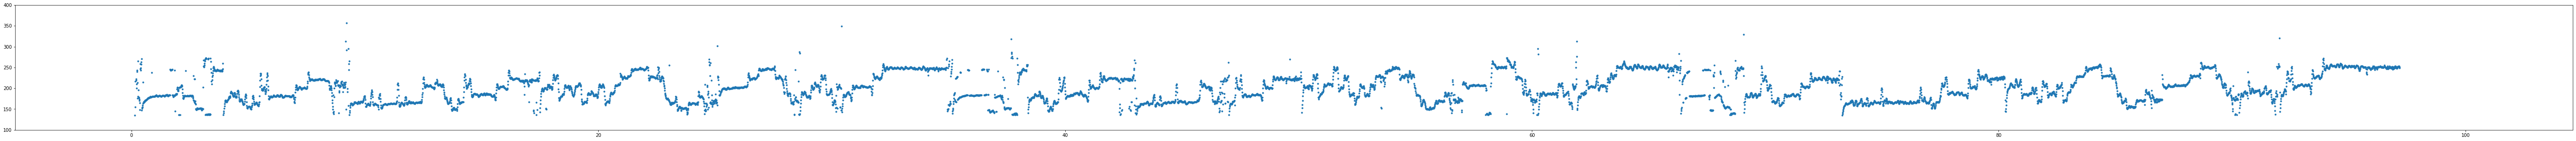

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Shermanduli - middle.mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

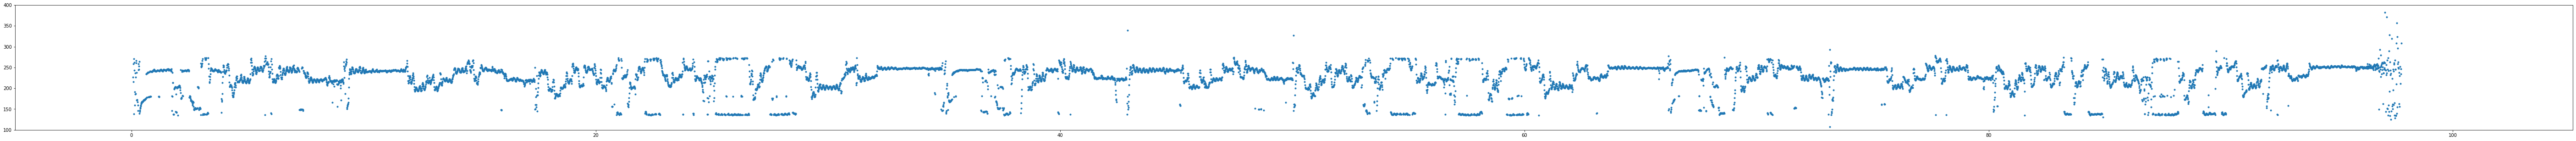

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Shermanduli - top.mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

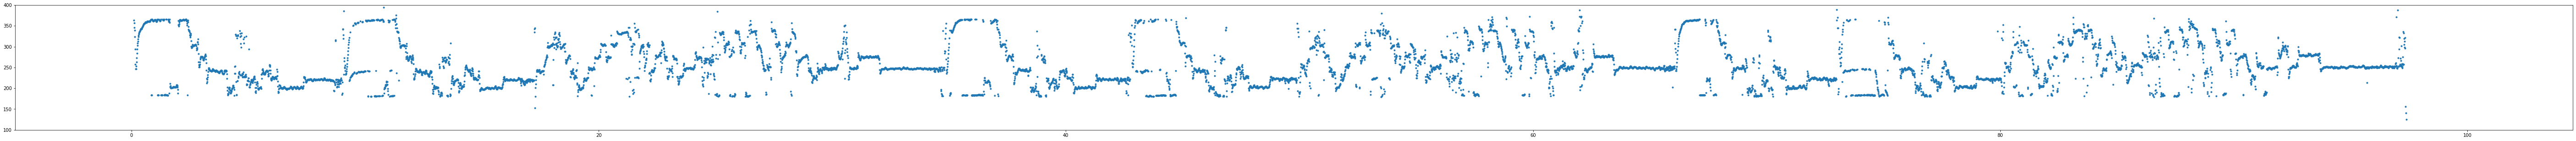

Teach Yourself Gurian Songs ,  Shvidk'atsa
Shvidk'atsa ,  {'headset': ["Shvidk'atsa - bass.mp3", "Shvidk'atsa - middle.mp3", "Shvidk'atsa - top.mp3"]}


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Shvidk'atsa - bass.mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 114 from t=5026518 to 5071500
Batch 115 from t=5070618 to 5115600
Batch 116 from t=5114718 to 5159700
Batch 117 from t=5158818 to 5203800
Batch 118 from t=5202918 to 5247900
Batch 119 from t=5247018 to 5264028
Yin final f0 estimates written to:  /Akamai/voice/data/pitches/yin/Teach Yourself Gurian Songs/Shvidk'atsa/Shvidk'atsa AHDS1M.txt


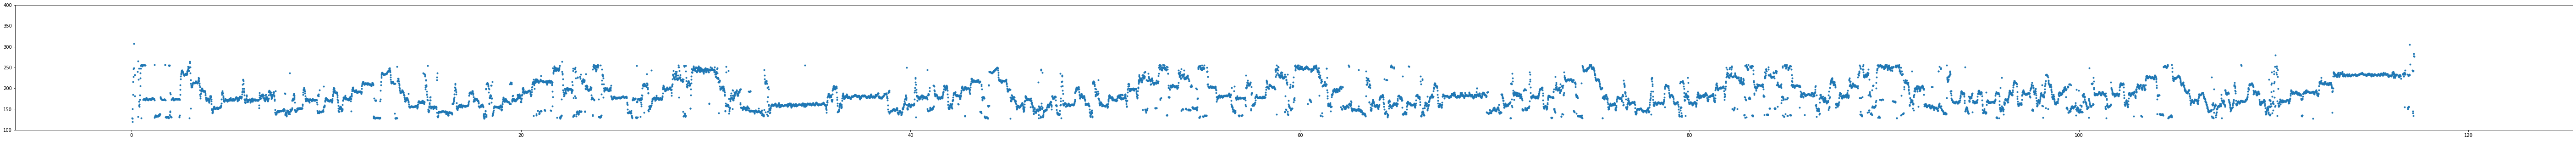

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Shvidk'atsa - middle.mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 114 from t=5026518 to 5071500
Batch 115 from t=5070618 to 5115600
Batch 116 from t=5114718 to 5159700
Batch 117 from t=5158818 to 5203800
Batch 118 from t=5202918 to 5247900
Batch 119 from t=5247018 to 5260572
Yin final f0 estimates written to:  /Akamai/voice/data/pitches/yin/Teach Yourself Gurian Songs/Shvidk'atsa/Shvidk'atsa AHDS2M.txt


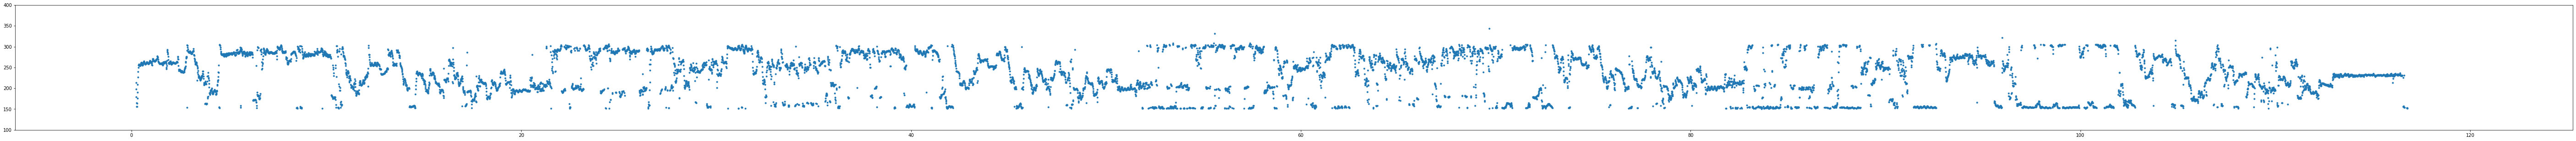

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Shvidk'atsa - top.mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 114 from t=5026518 to 5071500
Batch 115 from t=5070618 to 5115600
Batch 116 from t=5114718 to 5159700
Batch 117 from t=5158818 to 5203800
Batch 118 from t=5202918 to 5247900
Batch 119 from t=5247018 to 5258268
Yin final f0 estimates written to:  /Akamai/voice/data/pitches/yin/Teach Yourself Gurian Songs/Shvidk'atsa/Shvidk'atsa AHDS3M.txt


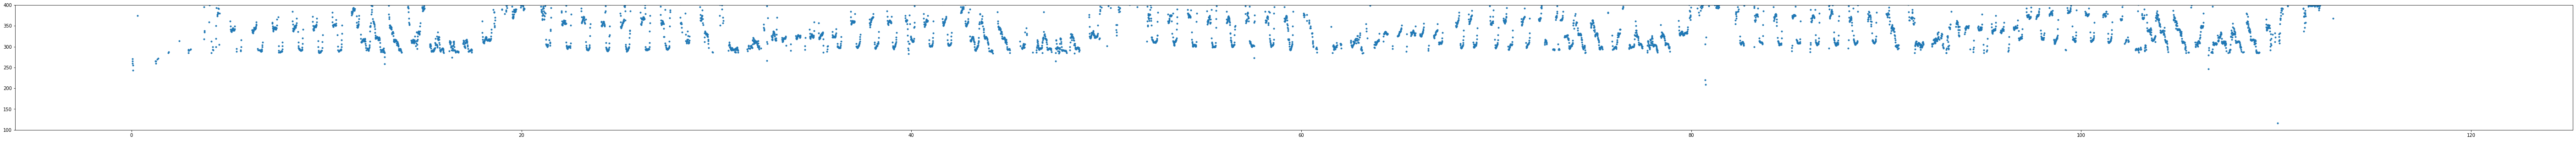

Teach Yourself Gurian Songs ,  Supris Khelkhvavi
Supris Khelkhvavi ,  {'headset': ['Supris Khelkhvavi - bass.mp3', 'Supris Khelkhvavi - middle.mp3', 'Supris Khelkhvavi - top.mp3']}


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Supris Khelkhvavi - bass.mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 68 from t=2997918 to 3042900
Batch 69 from t=3042018 to 3087000
Batch 70 from t=3086118 to 3131100
Batch 71 from t=3130218 to 3175200
Batch 72 from t=3174318 to 3219300
Batch 73 from t=3218418 to 3263400
Batch 74 from t=3262518 to 3307500
Batch 75 from t=3306618 to 3351600
Batch 76 from t=3350718 to 3395700
Batch 77 from t=3394818 to 3439800
Batch 78 from t=3438918 to 3483900
Batch 79 from t=3483018 to 3528000
Batch 80 from t=3527118 to 3572100
Batch 81 from t=3571218 to 3616200
Batch 82 from t=3615318 to 3660300
Batch 83 from t=3659418 to 3704400
Batch 84 from t=3703518 to 3748500
Batch 85 from t=3747618 to 3792600
Batch 86 from t=3791718 to 3836700
Batch 87 from t=3835818 to 3880800
Batch 88 from t=3879918 to 3924900
Batch 89 from t=3924018 to 3969000
Batch 90 from t=3968118 to 4013100
Batch 91 from t=4012218 to 4057200
Batch 92 from t=4056318 to 4101300
Batch 93 from t=4100418 to 4145400
Batch 94 from t=4144518 to 4189500
Batch 95 from t=4188618 to 4233600
Batch 96 from t=4232

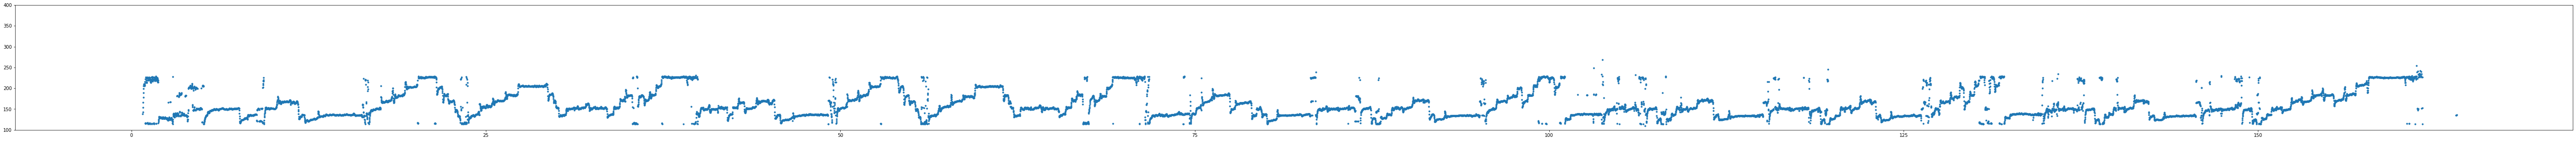

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Supris Khelkhvavi - middle.mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 68 from t=2997918 to 3042900
Batch 69 from t=3042018 to 3087000
Batch 70 from t=3086118 to 3131100
Batch 71 from t=3130218 to 3175200
Batch 72 from t=3174318 to 3219300
Batch 73 from t=3218418 to 3263400
Batch 74 from t=3262518 to 3307500
Batch 75 from t=3306618 to 3351600
Batch 76 from t=3350718 to 3395700
Batch 77 from t=3394818 to 3439800
Batch 78 from t=3438918 to 3483900
Batch 79 from t=3483018 to 3528000
Batch 80 from t=3527118 to 3572100
Batch 81 from t=3571218 to 3616200
Batch 82 from t=3615318 to 3660300
Batch 83 from t=3659418 to 3704400
Batch 84 from t=3703518 to 3748500
Batch 85 from t=3747618 to 3792600
Batch 86 from t=3791718 to 3836700
Batch 87 from t=3835818 to 3880800
Batch 88 from t=3879918 to 3924900
Batch 89 from t=3924018 to 3969000
Batch 90 from t=3968118 to 4013100
Batch 91 from t=4012218 to 4057200
Batch 92 from t=4056318 to 4101300
Batch 93 from t=4100418 to 4145400
Batch 94 from t=4144518 to 4189500
Batch 95 from t=4188618 to 4233600
Batch 96 from t=4232

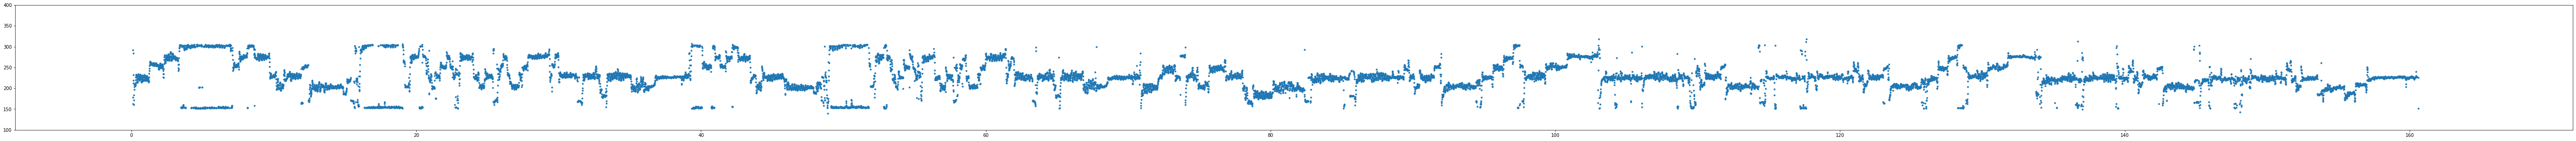

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Supris Khelkhvavi - top.mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 68 from t=2997918 to 3042900
Batch 69 from t=3042018 to 3087000
Batch 70 from t=3086118 to 3131100
Batch 71 from t=3130218 to 3175200
Batch 72 from t=3174318 to 3219300
Batch 73 from t=3218418 to 3263400
Batch 74 from t=3262518 to 3307500
Batch 75 from t=3306618 to 3351600
Batch 76 from t=3350718 to 3395700
Batch 77 from t=3394818 to 3439800
Batch 78 from t=3438918 to 3483900
Batch 79 from t=3483018 to 3528000
Batch 80 from t=3527118 to 3572100
Batch 81 from t=3571218 to 3616200
Batch 82 from t=3615318 to 3660300
Batch 83 from t=3659418 to 3704400
Batch 84 from t=3703518 to 3748500
Batch 85 from t=3747618 to 3792600
Batch 86 from t=3791718 to 3836700
Batch 87 from t=3835818 to 3880800
Batch 88 from t=3879918 to 3924900
Batch 89 from t=3924018 to 3969000
Batch 90 from t=3968118 to 4013100
Batch 91 from t=4012218 to 4057200
Batch 92 from t=4056318 to 4101300
Batch 93 from t=4100418 to 4145400
Batch 94 from t=4144518 to 4189500
Batch 95 from t=4188618 to 4233600
Batch 96 from t=4232

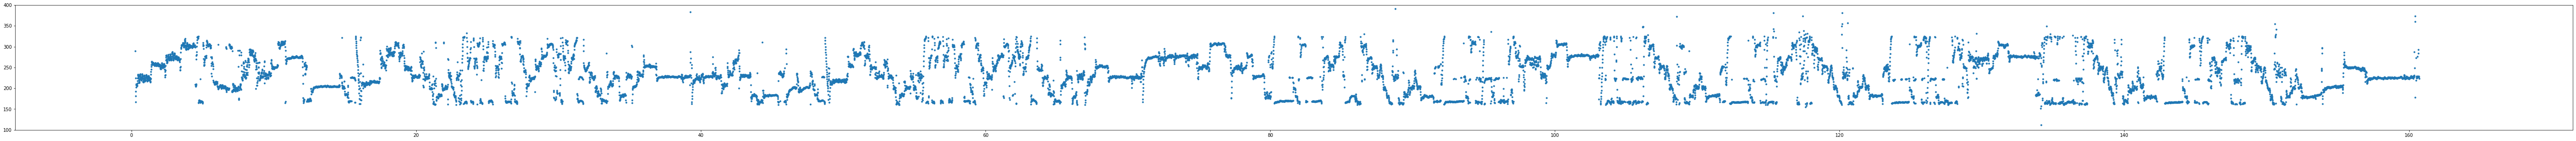

Teach Yourself Gurian Songs ,  Ts'amok'ruli
Ts'amok'ruli ,  {'headset': ["Ts'amok'ruli - bass.mp3", "Ts'amok'ruli - middle.mp3", "Ts'amok'ruli - top.mp3"]}


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Ts'amok'ruli - bass.mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Batch 104 from t=4585518 to 4630500
Batch 105 from t=4629618 to 4667292
Yin raw f0 estimates written to:  /Akamai/voice/data/pitches-raw/yin/Teach Yourself Gurian Songs/Ts'amok'ruli/Ts'amok'ruli AHDS1M.txt
Voice range:  114 228
Batch 0 from t=0 to 44100
Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058

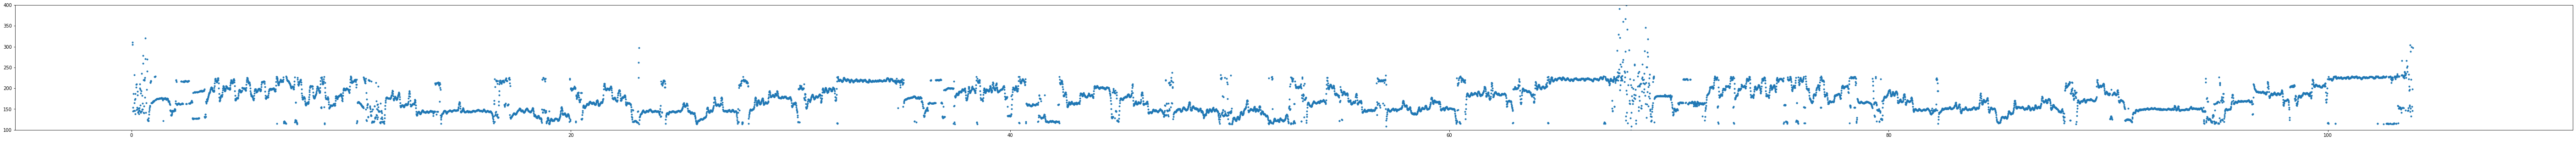

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Ts'amok'ruli - middle.mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

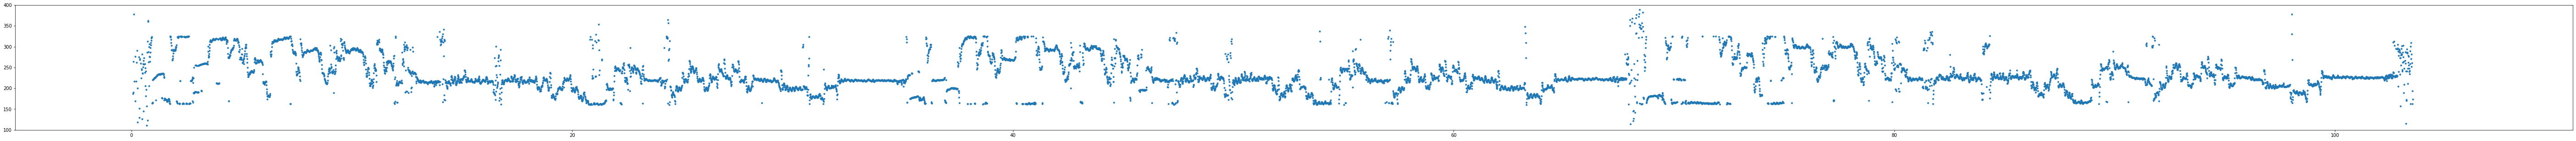

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Ts'amok'ruli - top.mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Batch 104 from t=4585518 to 4630500
Batch 105 from t=4629618 to 4633884
Yin raw f0 estimates written to:  /Akamai/voice/data/pitches-raw/yin/Teach Yourself Gurian Songs/Ts'amok'ruli/Ts'amok'ruli AHDS3M.txt
Voice range:  181 362
Batch 0 from t=0 to 44100
Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058

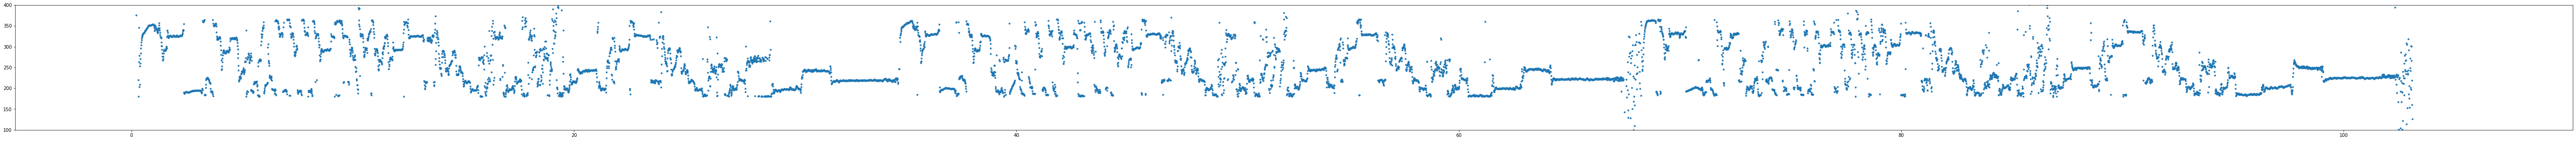

Teach Yourself Megrelian Songs ,  Ak'a Si Rekisho
mp3 ,  {'headset': ["Ak'a Si Rekisho (bass).mp3", "Ak'a Si Rekisho (middle).mp3", "Ak'a Si Rekisho (top).mp3"]}


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Ak'a Si Rekisho (bass).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 38 from t=1674918 to 1719900
Batch 39 from t=1719018 to 1764000
Batch 40 from t=1763118 to 1808100
Batch 41 from t=1807218 to 1852200
Batch 42 from t=1851318 to 1896300
Batch 43 from t=1895418 to 1940400
Batch 44 from t=1939518 to 1984500
Batch 45 from t=1983618 to 2028600
Batch 46 from t=2027718 to 2072700
Batch 47 from t=2071818 to 2116800
Batch 48 from t=2115918 to 2160900
Batch 49 from t=2160018 to 2205000
Batch 50 from t=2204118 to 2249100
Batch 51 from t=2248218 to 2293200
Batch 52 from t=2292318 to 2337300
Batch 53 from t=2336418 to 2381400
Batch 54 from t=2380518 to 2425500
Batch 55 from t=2424618 to 2469600
Batch 56 from t=2468718 to 2513700
Batch 57 from t=2512818 to 2557800
Batch 58 from t=2556918 to 2601900
Batch 59 from t=2601018 to 2646000
Batch 60 from t=2645118 to 2690100
Batch 61 from t=2689218 to 2734200
Batch 62 from t=2733318 to 2778300
Batch 63 from t=2777418 to 2822400
Batch 64 from t=2821518 to 2866500
Batch 65 from t=2865618 to 2910600
Batch 66 from t=2909

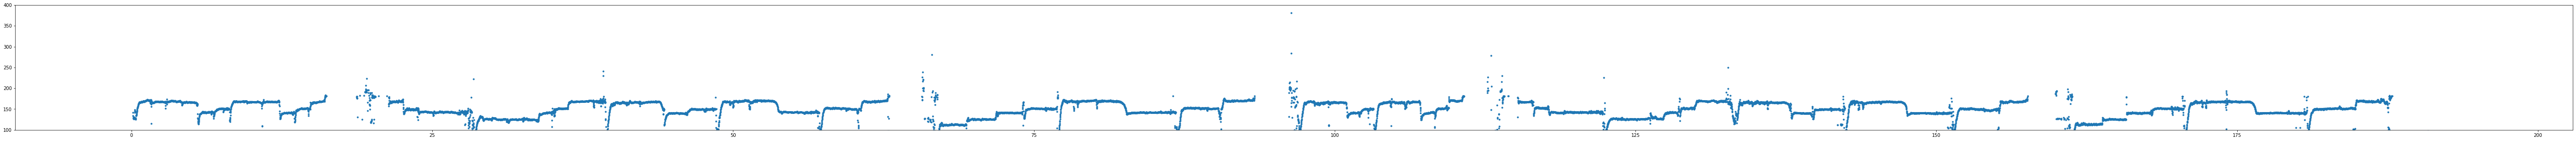

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Ak'a Si Rekisho (middle).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 38 from t=1674918 to 1719900
Batch 39 from t=1719018 to 1764000
Batch 40 from t=1763118 to 1808100
Batch 41 from t=1807218 to 1852200
Batch 42 from t=1851318 to 1896300
Batch 43 from t=1895418 to 1940400
Batch 44 from t=1939518 to 1984500
Batch 45 from t=1983618 to 2028600
Batch 46 from t=2027718 to 2072700
Batch 47 from t=2071818 to 2116800
Batch 48 from t=2115918 to 2160900
Batch 49 from t=2160018 to 2205000
Batch 50 from t=2204118 to 2249100
Batch 51 from t=2248218 to 2293200
Batch 52 from t=2292318 to 2337300
Batch 53 from t=2336418 to 2381400
Batch 54 from t=2380518 to 2425500
Batch 55 from t=2424618 to 2469600
Batch 56 from t=2468718 to 2513700
Batch 57 from t=2512818 to 2557800
Batch 58 from t=2556918 to 2601900
Batch 59 from t=2601018 to 2646000
Batch 60 from t=2645118 to 2690100
Batch 61 from t=2689218 to 2734200
Batch 62 from t=2733318 to 2778300
Batch 63 from t=2777418 to 2822400
Batch 64 from t=2821518 to 2866500
Batch 65 from t=2865618 to 2910600
Batch 66 from t=2909

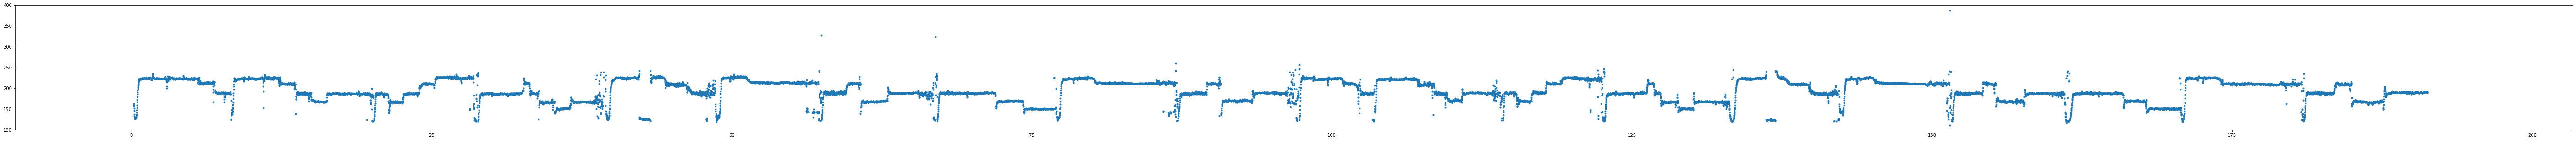

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Ak'a Si Rekisho (top).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 38 from t=1674918 to 1719900
Batch 39 from t=1719018 to 1764000
Batch 40 from t=1763118 to 1808100
Batch 41 from t=1807218 to 1852200
Batch 42 from t=1851318 to 1896300
Batch 43 from t=1895418 to 1940400
Batch 44 from t=1939518 to 1984500
Batch 45 from t=1983618 to 2028600
Batch 46 from t=2027718 to 2072700
Batch 47 from t=2071818 to 2116800
Batch 48 from t=2115918 to 2160900
Batch 49 from t=2160018 to 2205000
Batch 50 from t=2204118 to 2249100
Batch 51 from t=2248218 to 2293200
Batch 52 from t=2292318 to 2337300
Batch 53 from t=2336418 to 2381400
Batch 54 from t=2380518 to 2425500
Batch 55 from t=2424618 to 2469600
Batch 56 from t=2468718 to 2513700
Batch 57 from t=2512818 to 2557800
Batch 58 from t=2556918 to 2601900
Batch 59 from t=2601018 to 2646000
Batch 60 from t=2645118 to 2690100
Batch 61 from t=2689218 to 2734200
Batch 62 from t=2733318 to 2778300
Batch 63 from t=2777418 to 2822400
Batch 64 from t=2821518 to 2866500
Batch 65 from t=2865618 to 2910600
Batch 66 from t=2909

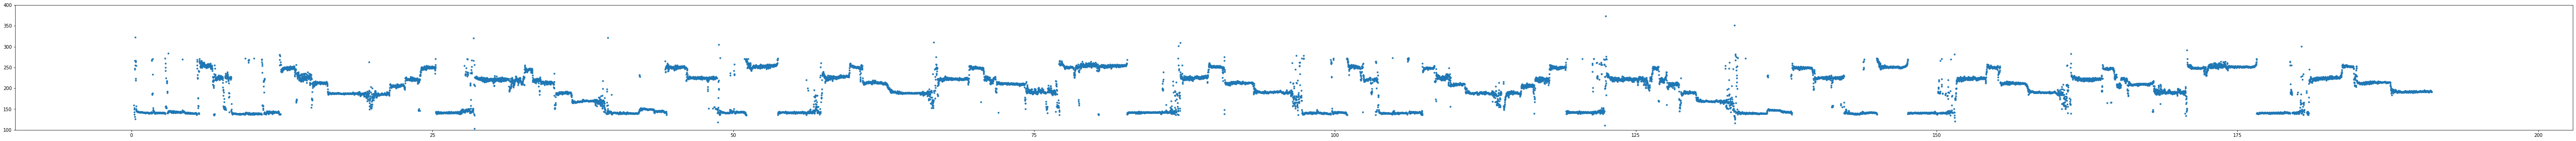

Teach Yourself Megrelian Songs ,  Gepshvat Ghvini
mp3 ,  {'headset': ['Gepshvat Ghvini (bass).mp3', 'Gepshvat Ghvini (middle).mp3', 'Gepshvat Ghvini (top).mp3']}


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Gepshvat Ghvini (bass).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 68 from t=2997918 to 3042900
Batch 69 from t=3042018 to 3087000
Batch 70 from t=3086118 to 3131100
Batch 71 from t=3130218 to 3175200
Batch 72 from t=3174318 to 3219300
Batch 73 from t=3218418 to 3263400
Batch 74 from t=3262518 to 3307500
Batch 75 from t=3306618 to 3351600
Batch 76 from t=3350718 to 3395700
Batch 77 from t=3394818 to 3439800
Batch 78 from t=3438918 to 3483900
Batch 79 from t=3483018 to 3528000
Batch 80 from t=3527118 to 3572100
Batch 81 from t=3571218 to 3616200
Batch 82 from t=3615318 to 3660300
Batch 83 from t=3659418 to 3704400
Batch 84 from t=3703518 to 3748500
Batch 85 from t=3747618 to 3792600
Batch 86 from t=3791718 to 3836700
Batch 87 from t=3835818 to 3880800
Batch 88 from t=3879918 to 3924900
Batch 89 from t=3924018 to 3969000
Batch 90 from t=3968118 to 4013100
Batch 91 from t=4012218 to 4057200
Batch 92 from t=4056318 to 4101300
Batch 93 from t=4100418 to 4145400
Batch 94 from t=4144518 to 4189500
Batch 95 from t=4188618 to 4233600
Batch 96 from t=4232

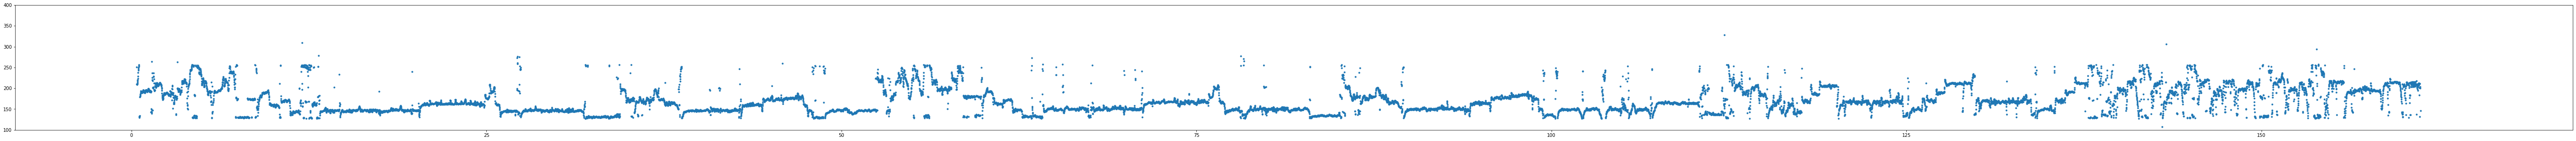

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Gepshvat Ghvini (middle).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 68 from t=2997918 to 3042900
Batch 69 from t=3042018 to 3087000
Batch 70 from t=3086118 to 3131100
Batch 71 from t=3130218 to 3175200
Batch 72 from t=3174318 to 3219300
Batch 73 from t=3218418 to 3263400
Batch 74 from t=3262518 to 3307500
Batch 75 from t=3306618 to 3351600
Batch 76 from t=3350718 to 3395700
Batch 77 from t=3394818 to 3439800
Batch 78 from t=3438918 to 3483900
Batch 79 from t=3483018 to 3528000
Batch 80 from t=3527118 to 3572100
Batch 81 from t=3571218 to 3616200
Batch 82 from t=3615318 to 3660300
Batch 83 from t=3659418 to 3704400
Batch 84 from t=3703518 to 3748500
Batch 85 from t=3747618 to 3792600
Batch 86 from t=3791718 to 3836700
Batch 87 from t=3835818 to 3880800
Batch 88 from t=3879918 to 3924900
Batch 89 from t=3924018 to 3969000
Batch 90 from t=3968118 to 4013100
Batch 91 from t=4012218 to 4057200
Batch 92 from t=4056318 to 4101300
Batch 93 from t=4100418 to 4145400
Batch 94 from t=4144518 to 4189500
Batch 95 from t=4188618 to 4233600
Batch 96 from t=4232

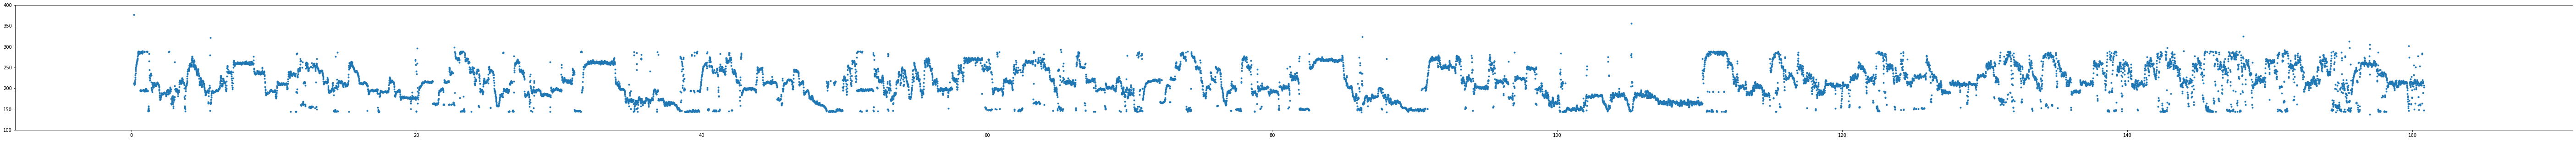

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Gepshvat Ghvini (top).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 68 from t=2997918 to 3042900
Batch 69 from t=3042018 to 3087000
Batch 70 from t=3086118 to 3131100
Batch 71 from t=3130218 to 3175200
Batch 72 from t=3174318 to 3219300
Batch 73 from t=3218418 to 3263400
Batch 74 from t=3262518 to 3307500
Batch 75 from t=3306618 to 3351600
Batch 76 from t=3350718 to 3395700
Batch 77 from t=3394818 to 3439800
Batch 78 from t=3438918 to 3483900
Batch 79 from t=3483018 to 3528000
Batch 80 from t=3527118 to 3572100
Batch 81 from t=3571218 to 3616200
Batch 82 from t=3615318 to 3660300
Batch 83 from t=3659418 to 3704400
Batch 84 from t=3703518 to 3748500
Batch 85 from t=3747618 to 3792600
Batch 86 from t=3791718 to 3836700
Batch 87 from t=3835818 to 3880800
Batch 88 from t=3879918 to 3924900
Batch 89 from t=3924018 to 3969000
Batch 90 from t=3968118 to 4013100
Batch 91 from t=4012218 to 4057200
Batch 92 from t=4056318 to 4101300
Batch 93 from t=4100418 to 4145400
Batch 94 from t=4144518 to 4189500
Batch 95 from t=4188618 to 4233600
Batch 96 from t=4232

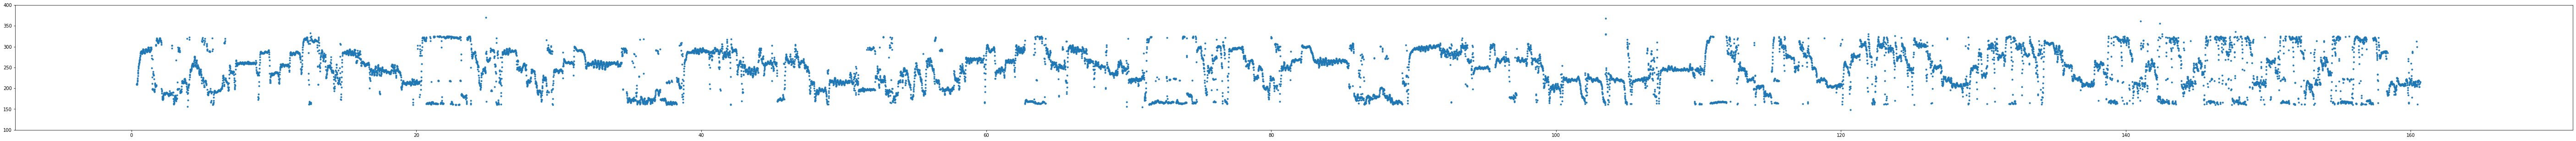

Teach Yourself Megrelian Songs ,  Io _ Chkin Kiana
mp3 ,  {'headset': ['Io _ Chkin Kiana (bass).mp3', 'Io _ Chkin Kiana (middle).mp3', 'Io _ Chkin Kiana (top).mp3']}


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Io _ Chkin Kiana (bass).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 103 from t=4541418 to 4586400
Batch 104 from t=4585518 to 4630500
Batch 105 from t=4629618 to 4674600
Batch 106 from t=4673718 to 4718700
Batch 107 from t=4717818 to 4762800
Batch 108 from t=4761918 to 4806900
Batch 109 from t=4806018 to 4851000
Batch 110 from t=4850118 to 4895100
Batch 111 from t=4894218 to 4939200
Batch 112 from t=4938318 to 4983300
Batch 113 from t=4982418 to 5027400
Batch 114 from t=5026518 to 5071500
Batch 115 from t=5070618 to 5115600
Batch 116 from t=5114718 to 5159700
Batch 117 from t=5158818 to 5203800
Batch 118 from t=5202918 to 5247900
Batch 119 from t=5247018 to 5292000
Batch 120 from t=5291118 to 5336100
Batch 121 from t=5335218 to 5380200
Batch 122 from t=5379318 to 5424300
Batch 123 from t=5423418 to 5468400
Batch 124 from t=5467518 to 5512500
Batch 125 from t=5511618 to 5556600
Batch 126 from t=5555718 to 5600700
Batch 127 from t=5599818 to 5644800
Batch 128 from t=5643918 to 5688900
Batch 129 from t=5688018 to 5711004
Yin final f0 estimates writt

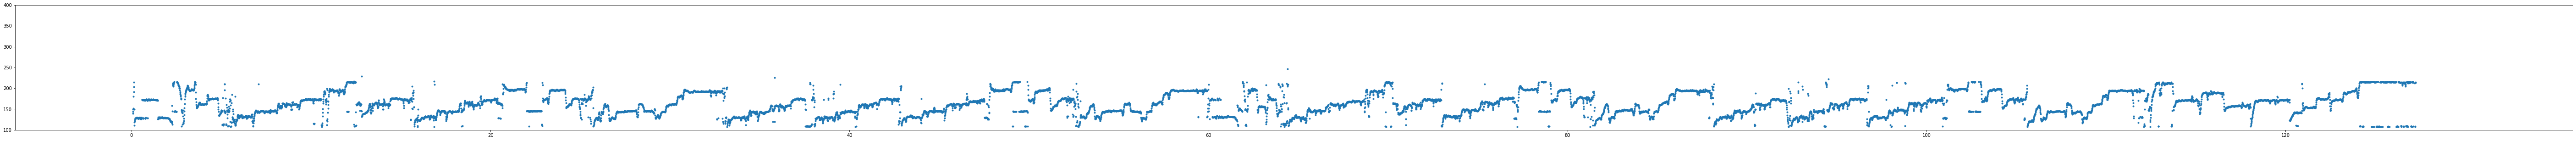

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Io _ Chkin Kiana (middle).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

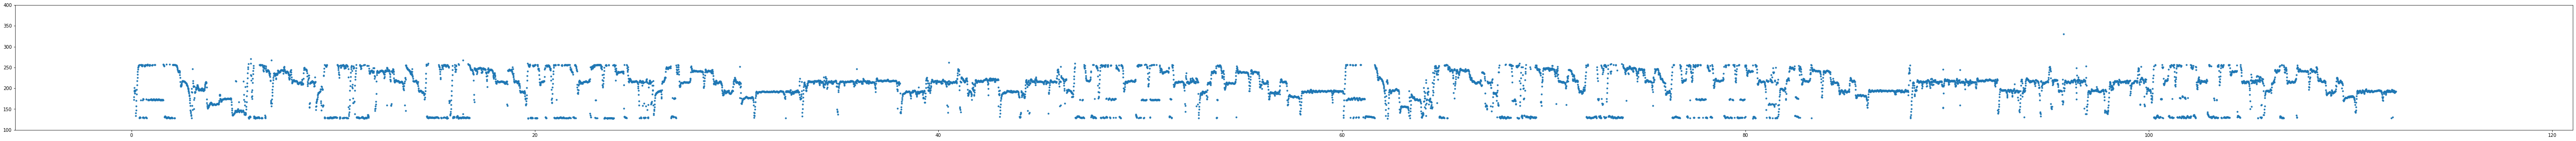

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Io _ Chkin Kiana (top).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 103 from t=4541418 to 4586400
Batch 104 from t=4585518 to 4630500
Batch 105 from t=4629618 to 4674600
Batch 106 from t=4673718 to 4718700
Batch 107 from t=4717818 to 4762800
Batch 108 from t=4761918 to 4806900
Batch 109 from t=4806018 to 4851000
Batch 110 from t=4850118 to 4895100
Batch 111 from t=4894218 to 4939200
Batch 112 from t=4938318 to 4983300
Batch 113 from t=4982418 to 5027400
Batch 114 from t=5026518 to 5071500
Batch 115 from t=5070618 to 5115600
Batch 116 from t=5114718 to 5159700
Batch 117 from t=5158818 to 5203800
Batch 118 from t=5202918 to 5247900
Batch 119 from t=5247018 to 5292000
Batch 120 from t=5291118 to 5336100
Batch 121 from t=5335218 to 5380200
Batch 122 from t=5379318 to 5424300
Batch 123 from t=5423418 to 5468400
Batch 124 from t=5467518 to 5512500
Batch 125 from t=5511618 to 5556600
Batch 126 from t=5555718 to 5600700
Batch 127 from t=5599818 to 5644800
Batch 128 from t=5643918 to 5688900
Batch 129 from t=5688018 to 5724828
Yin final f0 estimates writt

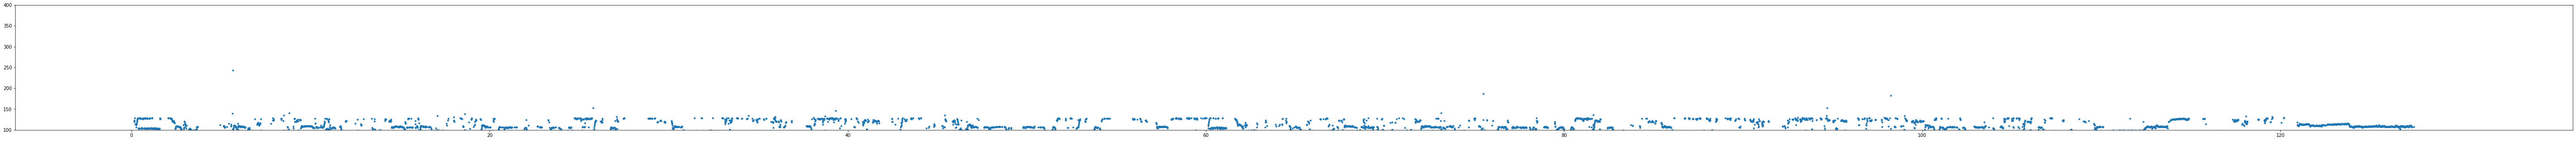

Teach Yourself Megrelian Songs ,  Mesishi Vardi
mp3 ,  {'headset': ['Mesishi Vardi (bass).mp3', 'Mesishi Vardi (middle).mp3', 'Mesishi Vardi (top).mp3']}


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Mesishi Vardi (bass).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

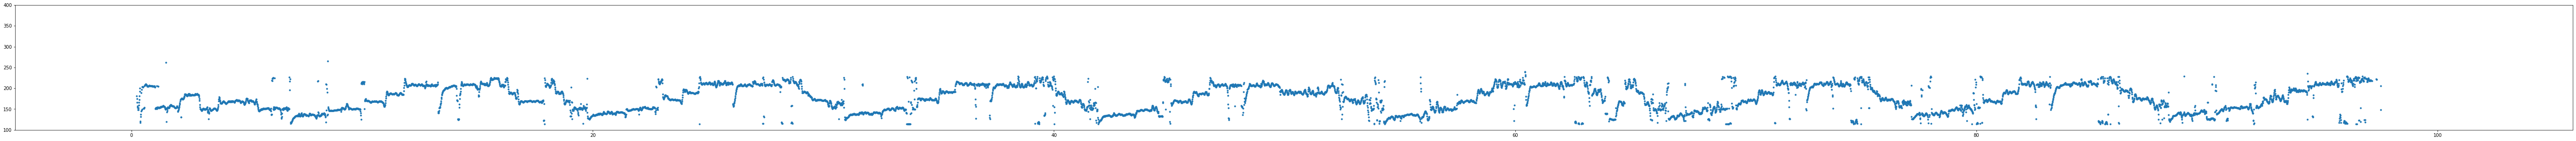

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Mesishi Vardi (middle).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

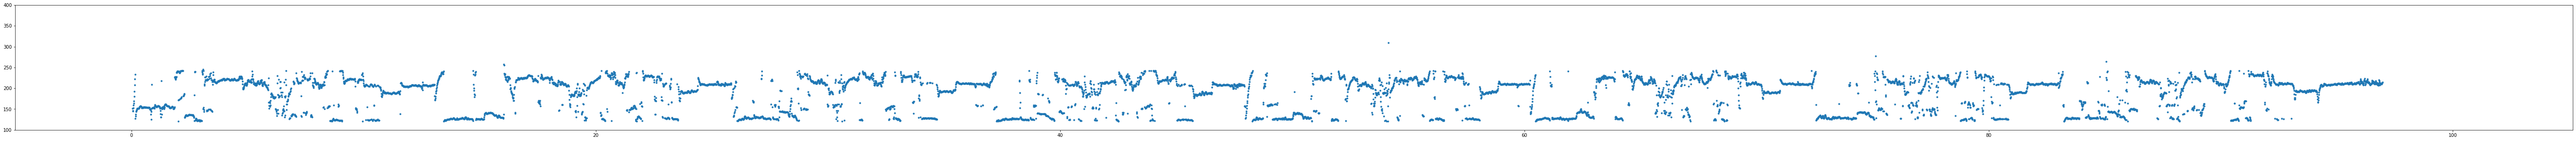

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Mesishi Vardi (top).mp3 sr =  44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 0 from t=0 to 44100
Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from 

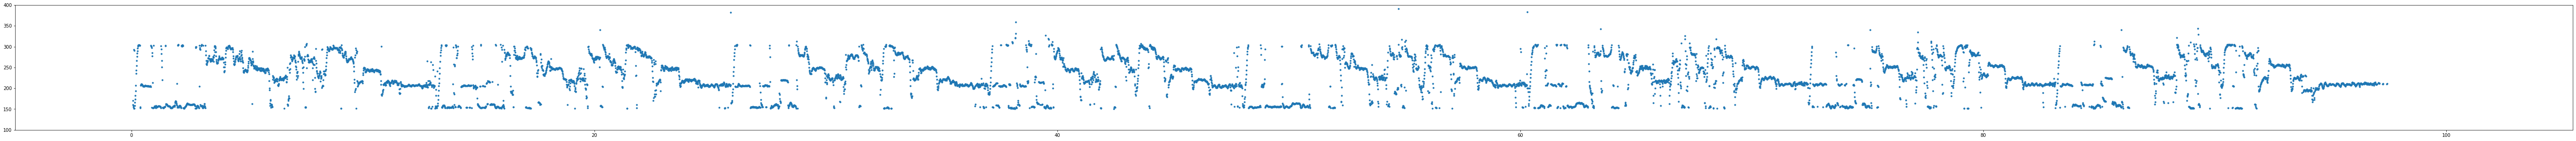

Teach Yourself Megrelian Songs ,  Meureme
mp3 ,  {'headset': ['Meureme (bass).mp3', 'Meureme (middle).mp3', 'Meureme (top).mp3']}


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Meureme (bass).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 54 from t=2380518 to 2425500
Batch 55 from t=2424618 to 2469600
Batch 56 from t=2468718 to 2513700
Batch 57 from t=2512818 to 2557800
Batch 58 from t=2556918 to 2601900
Batch 59 from t=2601018 to 2646000
Batch 60 from t=2645118 to 2690100
Batch 61 from t=2689218 to 2734200
Batch 62 from t=2733318 to 2778300
Batch 63 from t=2777418 to 2822400
Batch 64 from t=2821518 to 2866500
Batch 65 from t=2865618 to 2910600
Batch 66 from t=2909718 to 2954700
Batch 67 from t=2953818 to 2998800
Batch 68 from t=2997918 to 3042900
Batch 69 from t=3042018 to 3087000
Batch 70 from t=3086118 to 3131100
Batch 71 from t=3130218 to 3175200
Batch 72 from t=3174318 to 3219300
Batch 73 from t=3218418 to 3263400
Batch 74 from t=3262518 to 3307500
Batch 75 from t=3306618 to 3351600
Batch 76 from t=3350718 to 3395700
Batch 77 from t=3394818 to 3439800
Batch 78 from t=3438918 to 3483900
Batch 79 from t=3483018 to 3528000
Batch 80 from t=3527118 to 3572100
Batch 81 from t=3571218 to 3616200
Batch 82 from t=3615

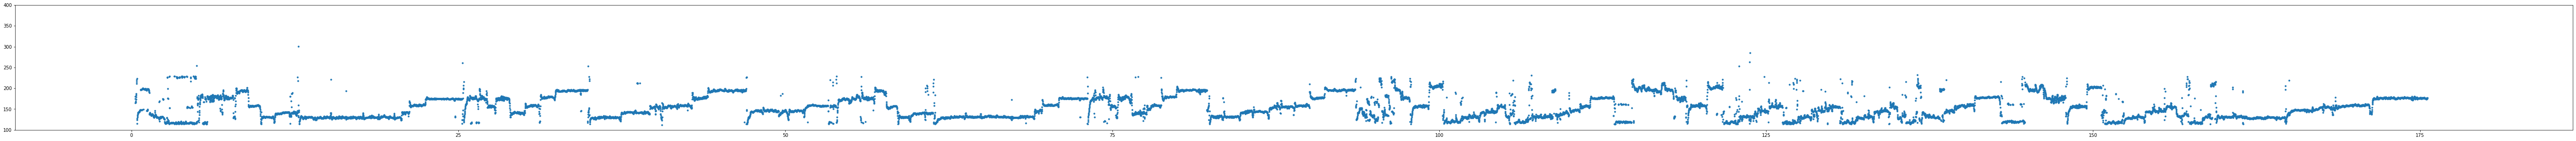

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Meureme (middle).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 54 from t=2380518 to 2425500
Batch 55 from t=2424618 to 2469600
Batch 56 from t=2468718 to 2513700
Batch 57 from t=2512818 to 2557800
Batch 58 from t=2556918 to 2601900
Batch 59 from t=2601018 to 2646000
Batch 60 from t=2645118 to 2690100
Batch 61 from t=2689218 to 2734200
Batch 62 from t=2733318 to 2778300
Batch 63 from t=2777418 to 2822400
Batch 64 from t=2821518 to 2866500
Batch 65 from t=2865618 to 2910600
Batch 66 from t=2909718 to 2954700
Batch 67 from t=2953818 to 2998800
Batch 68 from t=2997918 to 3042900
Batch 69 from t=3042018 to 3087000
Batch 70 from t=3086118 to 3131100
Batch 71 from t=3130218 to 3175200
Batch 72 from t=3174318 to 3219300
Batch 73 from t=3218418 to 3263400
Batch 74 from t=3262518 to 3307500
Batch 75 from t=3306618 to 3351600
Batch 76 from t=3350718 to 3395700
Batch 77 from t=3394818 to 3439800
Batch 78 from t=3438918 to 3483900
Batch 79 from t=3483018 to 3528000
Batch 80 from t=3527118 to 3572100
Batch 81 from t=3571218 to 3616200
Batch 82 from t=3615

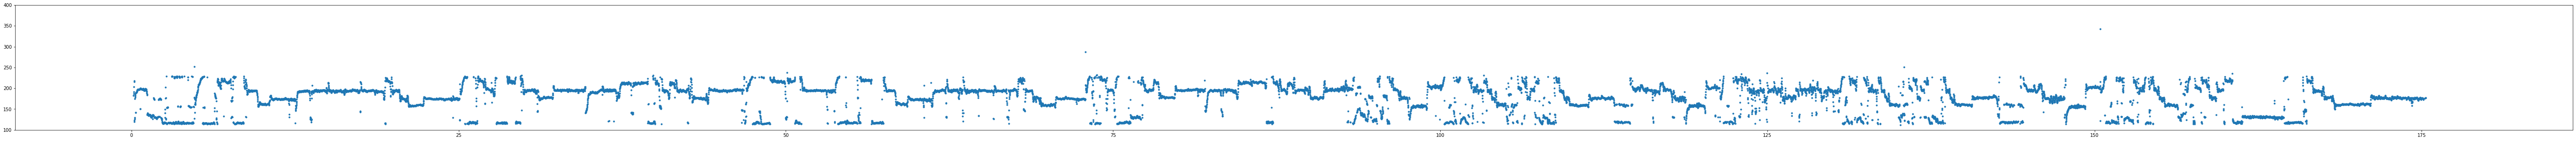

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Meureme (top).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 54 from t=2380518 to 2425500
Batch 55 from t=2424618 to 2469600
Batch 56 from t=2468718 to 2513700
Batch 57 from t=2512818 to 2557800
Batch 58 from t=2556918 to 2601900
Batch 59 from t=2601018 to 2646000
Batch 60 from t=2645118 to 2690100
Batch 61 from t=2689218 to 2734200
Batch 62 from t=2733318 to 2778300
Batch 63 from t=2777418 to 2822400
Batch 64 from t=2821518 to 2866500
Batch 65 from t=2865618 to 2910600
Batch 66 from t=2909718 to 2954700
Batch 67 from t=2953818 to 2998800
Batch 68 from t=2997918 to 3042900
Batch 69 from t=3042018 to 3087000
Batch 70 from t=3086118 to 3131100
Batch 71 from t=3130218 to 3175200
Batch 72 from t=3174318 to 3219300
Batch 73 from t=3218418 to 3263400
Batch 74 from t=3262518 to 3307500
Batch 75 from t=3306618 to 3351600
Batch 76 from t=3350718 to 3395700
Batch 77 from t=3394818 to 3439800
Batch 78 from t=3438918 to 3483900
Batch 79 from t=3483018 to 3528000
Batch 80 from t=3527118 to 3572100
Batch 81 from t=3571218 to 3616200
Batch 82 from t=3615

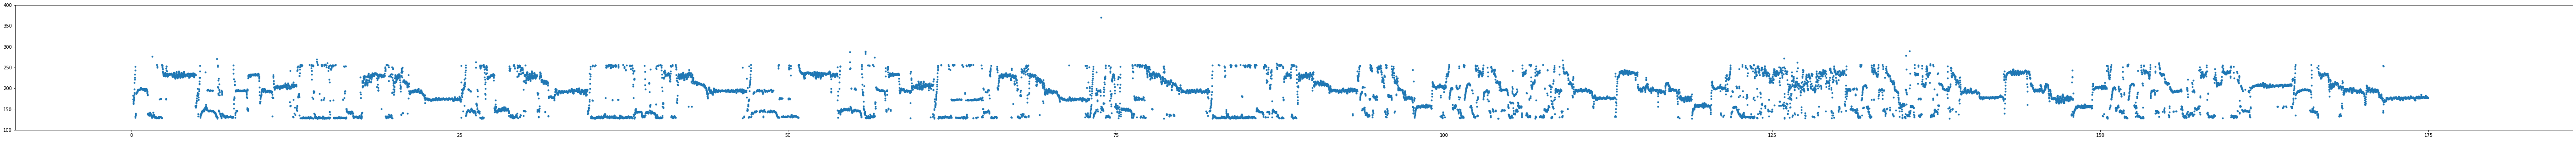

Teach Yourself Megrelian Songs ,  Mi Re Sotsodali_
mp3 ,  {'headset': ['Mi Re Sotsodali_ (bass).mp3', 'Mi Re Sotsodali_ (middle).mp3', 'Mi Re Sotsodali_ (top).mp3']}


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Mi Re Sotsodali_ (bass).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch 31 from t=1366218 to 1411200
Batch 32 from t=1410318 to 1455300
Batch 33 from t=1454418 to 1499400
Batch 34 from t=1498518 to 1543500
Batch 35 from t=1542618 to 1587600
Batch 36 from t=1586718 to 1631700
Batch 37 from t=1630818 to 1675800
Batch 38 from t=1674918 to 1719900
Batch 39 from t=1719018 to 1764000
Batch 40 from t=1763118 to 1808100
Batch 41 from t=1807218 to 1852200
Batch 42 from t=1851318 to 1896300
Batch 43 from t=1895418 to 1940400
Batch 44 from t=1939518 to 1984500
Batch 45 from t=1983618 to 2028600
Batch 46 from t=2027718 to 20

Batch 47 from t=2071818 to 2116800
Batch 48 from t=2115918 to 2160900
Batch 49 from t=2160018 to 2205000
Batch 50 from t=2204118 to 2249100
Batch 51 from t=2248218 to 2293200
Batch 52 from t=2292318 to 2337300
Batch 53 from t=2336418 to 2381400
Batch 54 from t=2380518 to 2425500
Batch 55 from t=2424618 to 2469600
Batch 56 from t=2468718 to 2513700
Batch 57 from t=2512818 to 2557800
Batch 58 from t=2556918 to 2601900
Batch 59 from t=2601018 to 2646000
Batch 60 from t=2645118 to 2690100
Batch 61 from t=2689218 to 2734200
Batch 62 from t=2733318 to 2778300
Batch 63 from t=2777418 to 2822400
Batch 64 from t=2821518 to 2866500
Batch 65 from t=2865618 to 2910600
Batch 66 from t=2909718 to 2954700
Batch 67 from t=2953818 to 2998800
Batch 68 from t=2997918 to 3042900
Batch 69 from t=3042018 to 3087000
Batch 70 from t=3086118 to 3131100
Batch 71 from t=3130218 to 3175200
Batch 72 from t=3174318 to 3219300
Batch 73 from t=3218418 to 3263400
Batch 74 from t=3262518 to 3307500
Batch 75 from t=3306

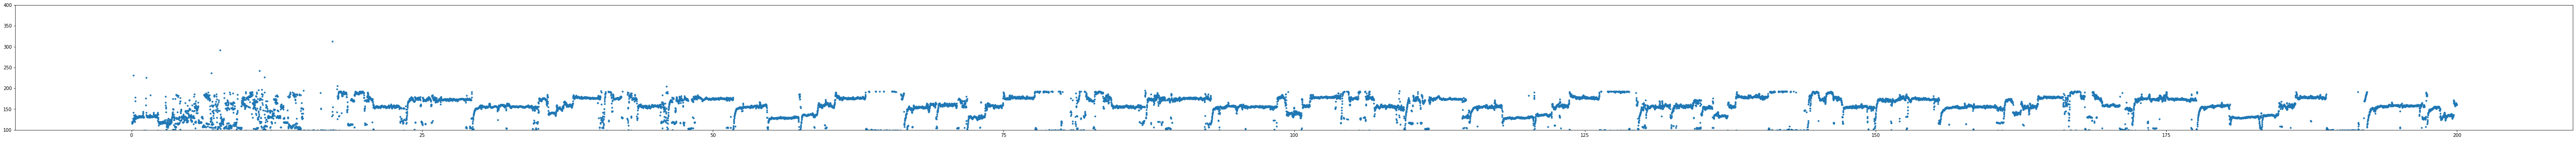

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Mi Re Sotsodali_ (middle).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 31 from t=1366218 to 1411200
Batch 32 from t=1410318 to 1455300
Batch 33 from t=1454418 to 1499400
Batch 34 from t=1498518 to 1543500
Batch 35 from t=1542618 to 1587600
Batch 36 from t=1586718 to 1631700
Batch 37 from t=1630818 to 1675800
Batch 38 from t=1674918 to 1719900
Batch 39 from t=1719018 to 1764000
Batch 40 from t=1763118 to 1808100
Batch 41 from t=1807218 to 1852200
Batch 42 from t=1851318 to 1896300
Batch 43 from t=1895418 to 1940400
Batch 44 from t=1939518 to 1984500
Batch 45 from t=1983618 to 2028600
Batch 46 from t=2027718 to 2072700
Batch 47 from t=2071818 to 2116800
Batch 48 from t=2115918 to 2160900
Batch 49 from t=2160018 to 2205000
Batch 50 from t=2204118 to 2249100
Batch 51 from t=2248218 to 2293200
Batch 52 from t=2292318 to 2337300
Batch 53 from t=2336418 to 2381400
Batch 54 from t=2380518 to 2425500
Batch 55 from t=2424618 to 2469600
Batch 56 from t=2468718 to 2513700
Batch 57 from t=2512818 to 2557800
Batch 58 from t=2556918 to 2601900
Batch 59 from t=2601

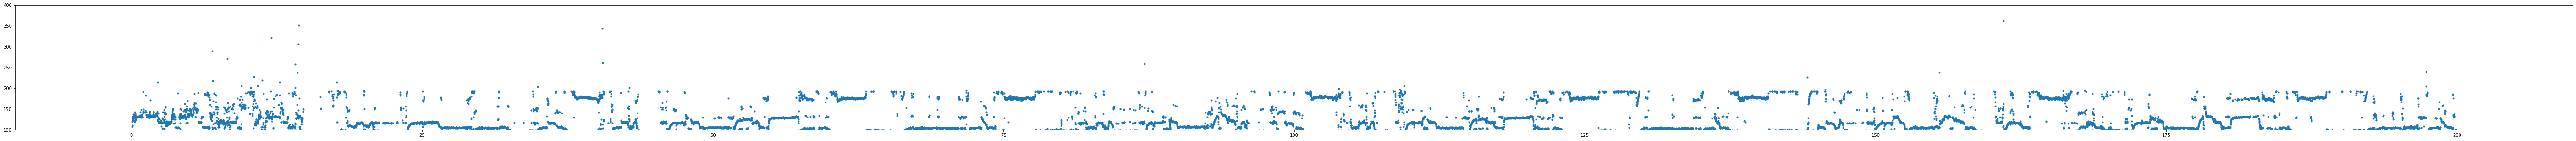

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Mi Re Sotsodali_ (top).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 31 from t=1366218 to 1411200
Batch 32 from t=1410318 to 1455300
Batch 33 from t=1454418 to 1499400
Batch 34 from t=1498518 to 1543500
Batch 35 from t=1542618 to 1587600
Batch 36 from t=1586718 to 1631700
Batch 37 from t=1630818 to 1675800
Batch 38 from t=1674918 to 1719900
Batch 39 from t=1719018 to 1764000
Batch 40 from t=1763118 to 1808100
Batch 41 from t=1807218 to 1852200
Batch 42 from t=1851318 to 1896300
Batch 43 from t=1895418 to 1940400
Batch 44 from t=1939518 to 1984500
Batch 45 from t=1983618 to 2028600
Batch 46 from t=2027718 to 2072700
Batch 47 from t=2071818 to 2116800
Batch 48 from t=2115918 to 2160900
Batch 49 from t=2160018 to 2205000
Batch 50 from t=2204118 to 2249100
Batch 51 from t=2248218 to 2293200
Batch 52 from t=2292318 to 2337300
Batch 53 from t=2336418 to 2381400
Batch 54 from t=2380518 to 2425500
Batch 55 from t=2424618 to 2469600
Batch 56 from t=2468718 to 2513700
Batch 57 from t=2512818 to 2557800
Batch 58 from t=2556918 to 2601900
Batch 59 from t=2601

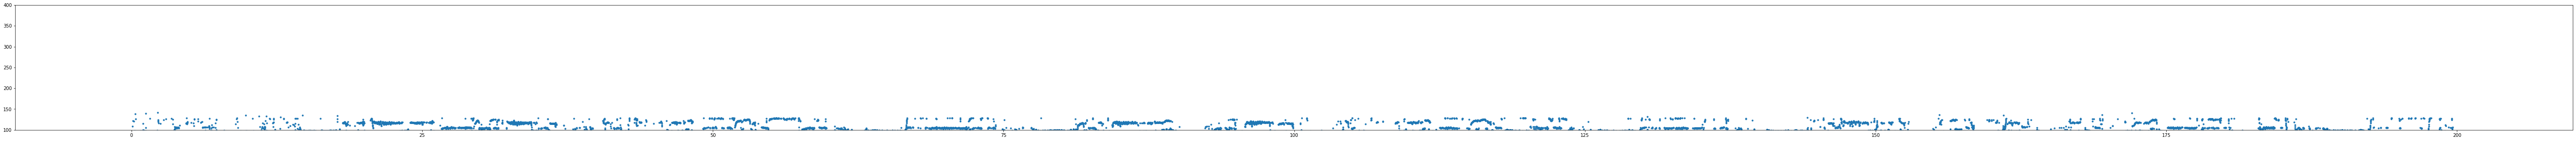

Teach Yourself Megrelian Songs ,  Mole Chit'i Gilakhe
mp3 ,  {'headset': ["Mole Chit'i Gilakhe (bass).mp3", "Mole Chit'i Gilakhe (middle).mp3", "Mole Chit'i Gilakhe (top).mp3"]}


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Mole Chit'i Gilakhe (bass).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 85 from t=3747618 to 3792600
Batch 86 from t=3791718 to 3836700
Batch 87 from t=3835818 to 3880800
Batch 88 from t=3879918 to 3924900
Batch 89 from t=3924018 to 3969000
Batch 90 from t=3968118 to 4013100
Batch 91 from t=4012218 to 4057200
Batch 92 from t=4056318 to 4101300
Batch 93 from t=4100418 to 4145400
Batch 94 from t=4144518 to 4189500
Batch 95 from t=4188618 to 4233600
Batch 96 from t=4232718 to 4277700
Batch 97 from t=4276818 to 4321800
Batch 98 from t=4320918 to 4365900
Batch 99 from t=4365018 to 4410000
Batch 100 from t=4409118 to 4454100
Batch 101 from t=4453218 to 4498200
Batch 102 from t=4497318 to 4542300
Batch 103 from t=4541418 to 4586400
Batch 104 from t=4585518 to 4630500
Batch 105 from t=4629618 to 4674600
Batch 106 from t=4673718 to 4718700
Batch 107 from t=4717818 to 4762800
Batch 108 from t=4761918 to 4806900
Batch 109 from t=4806018 to 4851000
Batch 110 from t=4850118 to 4895100
Batch 111 from t=4894218 to 4939200
Batch 112 from t=4938318 to 4983300
Batch 1

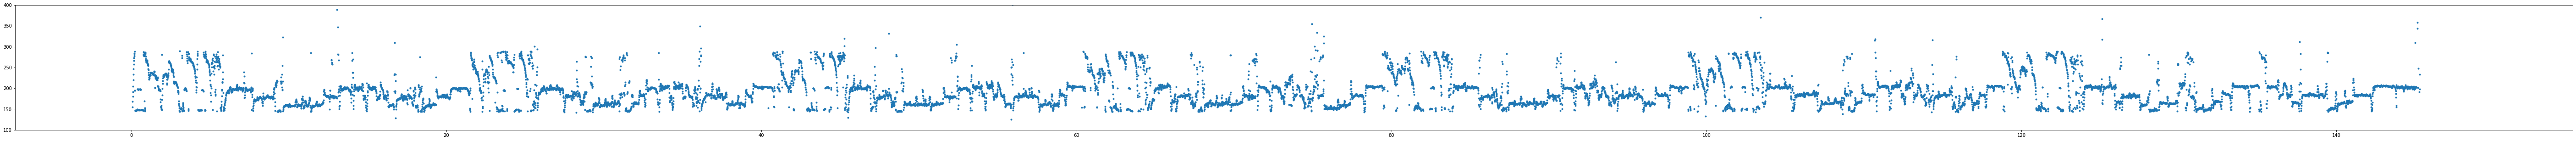

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Mole Chit'i Gilakhe (middle).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 85 from t=3747618 to 3792600
Batch 86 from t=3791718 to 3836700
Batch 87 from t=3835818 to 3880800
Batch 88 from t=3879918 to 3924900
Batch 89 from t=3924018 to 3969000
Batch 90 from t=3968118 to 4013100
Batch 91 from t=4012218 to 4057200
Batch 92 from t=4056318 to 4101300
Batch 93 from t=4100418 to 4145400
Batch 94 from t=4144518 to 4189500
Batch 95 from t=4188618 to 4233600
Batch 96 from t=4232718 to 4277700
Batch 97 from t=4276818 to 4321800
Batch 98 from t=4320918 to 4365900
Batch 99 from t=4365018 to 4410000
Batch 100 from t=4409118 to 4454100
Batch 101 from t=4453218 to 4498200
Batch 102 from t=4497318 to 4542300
Batch 103 from t=4541418 to 4586400
Batch 104 from t=4585518 to 4630500
Batch 105 from t=4629618 to 4674600
Batch 106 from t=4673718 to 4718700
Batch 107 from t=4717818 to 4762800
Batch 108 from t=4761918 to 4806900
Batch 109 from t=4806018 to 4851000
Batch 110 from t=4850118 to 4895100
Batch 111 from t=4894218 to 4939200
Batch 112 from t=4938318 to 4983300
Batch 1

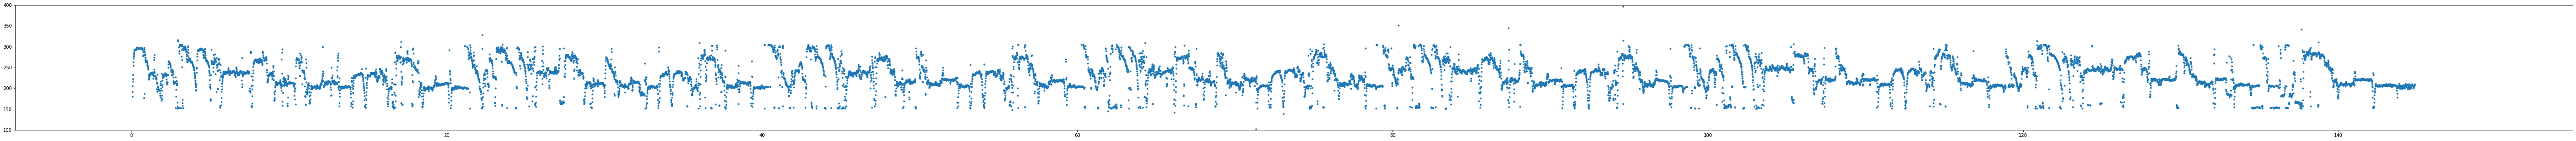

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Mole Chit'i Gilakhe (top).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 85 from t=3747618 to 3792600
Batch 86 from t=3791718 to 3836700
Batch 87 from t=3835818 to 3880800
Batch 88 from t=3879918 to 3924900
Batch 89 from t=3924018 to 3969000
Batch 90 from t=3968118 to 4013100
Batch 91 from t=4012218 to 4057200
Batch 92 from t=4056318 to 4101300
Batch 93 from t=4100418 to 4145400
Batch 94 from t=4144518 to 4189500
Batch 95 from t=4188618 to 4233600
Batch 96 from t=4232718 to 4277700
Batch 97 from t=4276818 to 4321800
Batch 98 from t=4320918 to 4365900
Batch 99 from t=4365018 to 4410000
Batch 100 from t=4409118 to 4454100
Batch 101 from t=4453218 to 4498200
Batch 102 from t=4497318 to 4542300
Batch 103 from t=4541418 to 4586400
Batch 104 from t=4585518 to 4630500
Batch 105 from t=4629618 to 4674600
Batch 106 from t=4673718 to 4718700
Batch 107 from t=4717818 to 4762800
Batch 108 from t=4761918 to 4806900
Batch 109 from t=4806018 to 4851000
Batch 110 from t=4850118 to 4895100
Batch 111 from t=4894218 to 4939200
Batch 112 from t=4938318 to 4983300
Batch 1

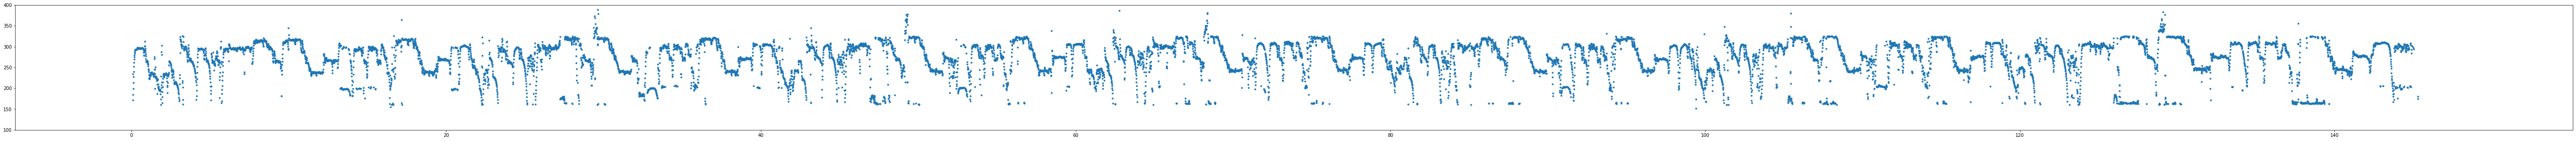

Teach Yourself Megrelian Songs ,  O Da
mp3 ,  {'headset': ['O Da (bass).mp3', 'O Da (middle).mp3', 'O Da (top).mp3']}


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  O Da (bass).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 107 from t=4717818 to 4762800
Batch 108 from t=4761918 to 4806900
Batch 109 from t=4806018 to 4851000
Batch 110 from t=4850118 to 4895100
Batch 111 from t=4894218 to 4939200
Batch 112 from t=4938318 to 4983300
Batch 113 from t=4982418 to 5027400
Batch 114 from t=5026518 to 5071500
Batch 115 from t=5070618 to 5115600
Batch 116 from t=5114718 to 5159700
Batch 117 from t=5158818 to 5203800
Batch 118 from t=5202918 to 5247900
Batch 119 from t=5247018 to 5292000
Batch 120 from t=5291118 to 5336100
Batch 121 from t=5335218 to 5380200
Batch 122 from t=5379318 to 5424300
Batch 123 from t=5423418 to 5468400
Batch 124 from t=5467518 to 5512500
Batch 125 from t=5511618 to 5556600
Batch 126 from t=5555718 to 5581980
Yin final f0 estimates written to:  /Akamai/voice/data/pitches/yin/Teach Yourself Megrelian Songs/O Da/O Da AHDS1M.txt


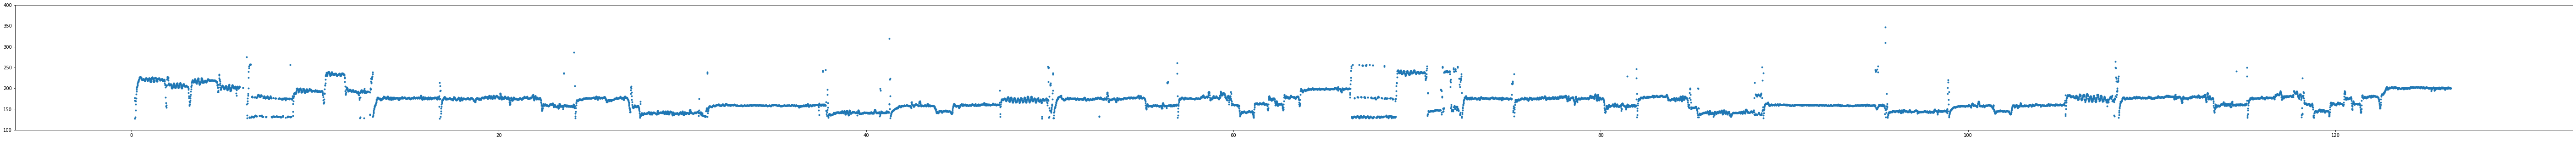

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  O Da (middle).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 105 from t=4629618 to 4674600
Batch 106 from t=4673718 to 4718700
Batch 107 from t=4717818 to 4762800
Batch 108 from t=4761918 to 4806900
Batch 109 from t=4806018 to 4851000
Batch 110 from t=4850118 to 4895100
Batch 111 from t=4894218 to 4939200
Batch 112 from t=4938318 to 4983300
Batch 113 from t=4982418 to 5027400
Batch 114 from t=5026518 to 5071500
Batch 115 from t=5070618 to 5115600
Batch 116 from t=5114718 to 5159700
Batch 117 from t=5158818 to 5203800
Batch 118 from t=5202918 to 5247900
Batch 119 from t=5247018 to 5292000
Batch 120 from t=5291118 to 5336100
Batch 121 from t=5335218 to 5380200
Batch 122 from t=5379318 to 5424300
Batch 123 from t=5423418 to 5468400
Batch 124 from t=5467518 to 5512500
Batch 125 from t=5511618 to 5556600
Batch 126 from t=5555718 to 5600700
Batch 127 from t=5599818 to 5644800
Batch 128 from t=5643918 to 5655708
Yin final f0 estimates written to:  /Akamai/voice/data/pitches/yin/Teach Yourself Megrelian Songs/O Da/O Da AHDS2M.txt


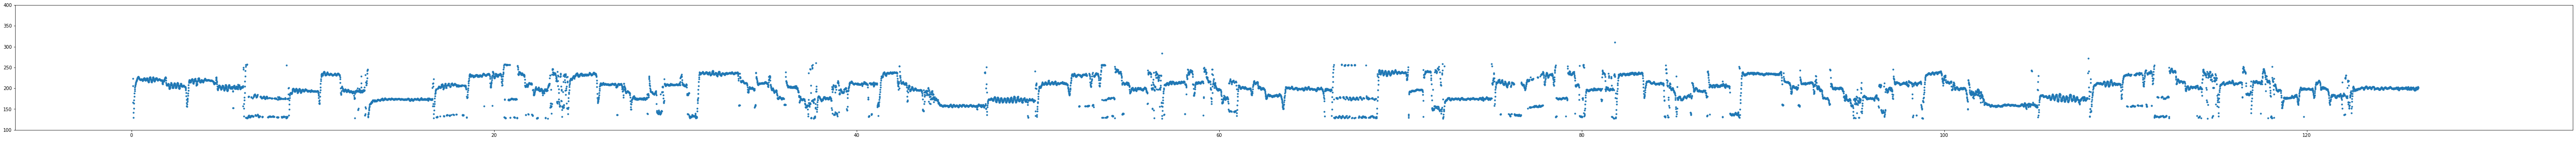

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  O Da (top).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 105 from t=4629618 to 4674600
Batch 106 from t=4673718 to 4718700
Batch 107 from t=4717818 to 4762800
Batch 108 from t=4761918 to 4806900
Batch 109 from t=4806018 to 4851000
Batch 110 from t=4850118 to 4895100
Batch 111 from t=4894218 to 4939200
Batch 112 from t=4938318 to 4983300
Batch 113 from t=4982418 to 5027400
Batch 114 from t=5026518 to 5071500
Batch 115 from t=5070618 to 5115600
Batch 116 from t=5114718 to 5159700
Batch 117 from t=5158818 to 5203800
Batch 118 from t=5202918 to 5247900
Batch 119 from t=5247018 to 5292000
Batch 120 from t=5291118 to 5336100
Batch 121 from t=5335218 to 5380200
Batch 122 from t=5379318 to 5424300
Batch 123 from t=5423418 to 5468400
Batch 124 from t=5467518 to 5512500
Batch 125 from t=5511618 to 5556600
Batch 126 from t=5555718 to 5600700
Batch 127 from t=5599818 to 5644800
Batch 128 from t=5643918 to 5670684
Yin final f0 estimates written to:  /Akamai/voice/data/pitches/yin/Teach Yourself Megrelian Songs/O Da/O Da AHDS3M.txt


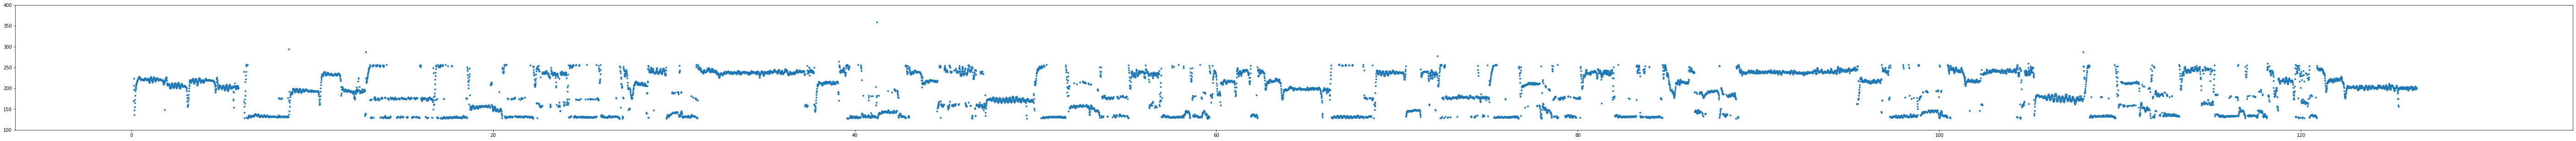

Teach Yourself Megrelian Songs ,  Vojanudi Chkim Jargvals
mp3 ,  {'headset': ['Vojanudi Chkim Jargvals (bass).mp3', 'Vojanudi Chkim Jargvals (middle).mp3', 'Vojanudi Chkim Jargvals (top).mp3']}


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Vojanudi Chkim Jargvals (bass).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 102 from t=4497318 to 4542300
Batch 103 from t=4541418 to 4586400
Batch 104 from t=4585518 to 4630500
Batch 105 from t=4629618 to 4674600
Batch 106 from t=4673718 to 4718700
Batch 107 from t=4717818 to 4762800
Batch 108 from t=4761918 to 4806900
Batch 109 from t=4806018 to 4851000
Batch 110 from t=4850118 to 4895100
Batch 111 from t=4894218 to 4939200
Batch 112 from t=4938318 to 4983300
Batch 113 from t=4982418 to 5027400
Batch 114 from t=5026518 to 5071500
Batch 115 from t=5070618 to 5115600
Batch 116 from t=5114718 to 5159700
Batch 117 from t=5158818 to 5203800
Batch 118 from t=5202918 to 5247900
Batch 119 from t=5247018 to 5292000
Batch 120 from t=5291118 to 5336100
Batch 121 from t=5335218 to 5380200
Batch 122 from t=5379318 to 5424300
Batch 123 from t=5423418 to 5468400
Batch 124 from t=5467518 to 5512500
Batch 125 from t=5511618 to 5556600
Batch 126 from t=5555718 to 5600700
Batch 127 from t=5599818 to 5644800
Batch 128 from t=5643918 to 5688900
Batch 129 from t=5688018 to 

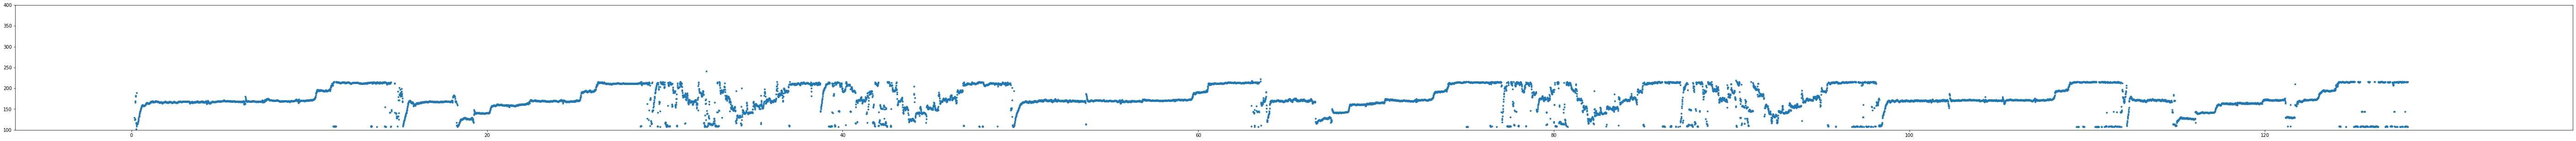

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Vojanudi Chkim Jargvals (middle).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 102 from t=4497318 to 4542300
Batch 103 from t=4541418 to 4586400
Batch 104 from t=4585518 to 4630500
Batch 105 from t=4629618 to 4674600
Batch 106 from t=4673718 to 4718700
Batch 107 from t=4717818 to 4762800
Batch 108 from t=4761918 to 4806900
Batch 109 from t=4806018 to 4851000
Batch 110 from t=4850118 to 4895100
Batch 111 from t=4894218 to 4939200
Batch 112 from t=4938318 to 4983300
Batch 113 from t=4982418 to 5027400
Batch 114 from t=5026518 to 5071500
Batch 115 from t=5070618 to 5115600
Batch 116 from t=5114718 to 5159700
Batch 117 from t=5158818 to 5203800
Batch 118 from t=5202918 to 5247900
Batch 119 from t=5247018 to 5292000
Batch 120 from t=5291118 to 5336100
Batch 121 from t=5335218 to 5380200
Batch 122 from t=5379318 to 5424300
Batch 123 from t=5423418 to 5468400
Batch 124 from t=5467518 to 5512500
Batch 125 from t=5511618 to 5556600
Batch 126 from t=5555718 to 5600700
Batch 127 from t=5599818 to 5644800
Batch 128 from t=5643918 to 5688900
Batch 129 from t=5688018 to 

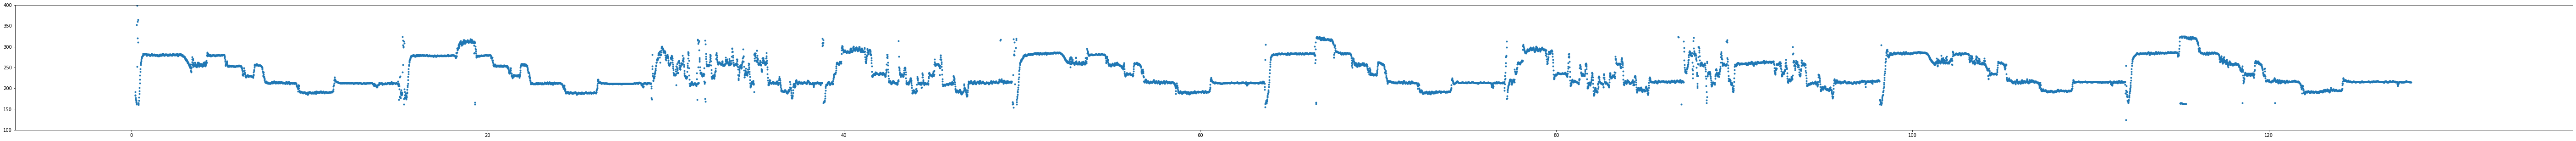

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Working on audio file:  Vojanudi Chkim Jargvals (top).mp3 sr =  44100
Batch 0 from t=0 to 44100


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Batch 1 from t=43218 to 88200
Batch 2 from t=87318 to 132300
Batch 3 from t=131418 to 176400
Batch 4 from t=175518 to 220500
Batch 5 from t=219618 to 264600
Batch 6 from t=263718 to 308700
Batch 7 from t=307818 to 352800
Batch 8 from t=351918 to 396900
Batch 9 from t=396018 to 441000
Batch 10 from t=440118 to 485100
Batch 11 from t=484218 to 529200
Batch 12 from t=528318 to 573300
Batch 13 from t=572418 to 617400
Batch 14 from t=616518 to 661500
Batch 15 from t=660618 to 705600
Batch 16 from t=704718 to 749700
Batch 17 from t=748818 to 793800
Batch 18 from t=792918 to 837900
Batch 19 from t=837018 to 882000
Batch 20 from t=881118 to 926100
Batch 21 from t=925218 to 970200
Batch 22 from t=969318 to 1014300
Batch 23 from t=1013418 to 1058400
Batch 24 from t=1057518 to 1102500
Batch 25 from t=1101618 to 1146600
Batch 26 from t=1145718 to 1190700
Batch 27 from t=1189818 to 1234800
Batch 28 from t=1233918 to 1278900
Batch 29 from t=1278018 to 1323000
Batch 30 from t=1322118 to 1367100
Batch

Batch 102 from t=4497318 to 4542300
Batch 103 from t=4541418 to 4586400
Batch 104 from t=4585518 to 4630500
Batch 105 from t=4629618 to 4674600
Batch 106 from t=4673718 to 4718700
Batch 107 from t=4717818 to 4762800
Batch 108 from t=4761918 to 4806900
Batch 109 from t=4806018 to 4851000
Batch 110 from t=4850118 to 4895100
Batch 111 from t=4894218 to 4939200
Batch 112 from t=4938318 to 4983300
Batch 113 from t=4982418 to 5027400
Batch 114 from t=5026518 to 5071500
Batch 115 from t=5070618 to 5115600
Batch 116 from t=5114718 to 5159700
Batch 117 from t=5158818 to 5203800
Batch 118 from t=5202918 to 5247900
Batch 119 from t=5247018 to 5292000
Batch 120 from t=5291118 to 5336100
Batch 121 from t=5335218 to 5380200
Batch 122 from t=5379318 to 5424300
Batch 123 from t=5423418 to 5468400


In [ ]:
import re
from os import makedirs

root = '/Akamai/voice/data/'
alg = 'yin'
collections = ['Scherbaum Mshavanadze', 'Teach Yourself Gurian Songs', 'Teach Yourself Megrelian Songs']
for coll in collections:
    songdirs = [d for d in listdir(join(root,coll)) \
     if isdir(join(root, coll, d)) and re.match("[A-Z]+", d) != None]
    for sd in songdirs: 
        debug = 1
        print(coll, ", ", sd)
        
        # The Megrelian collection has all its mp3s in one sd called 'mp3'
        (sd_data, files) = getFiles(coll, sd, debug)
        print(sd_data, ", ", files)

        for mic in files:
            for f in files[mic]:
                f0rawdir = join(root, "pitches-raw", alg, coll, sd)
                makedirs(f0rawdir, exist_ok=True)
                f0dir = join(root, "pitches", alg, coll, sd)
                makedirs(f0dir, exist_ok=True)
                data_path = join(root, coll, sd_data, f)
                f0rawfile = join(f0rawdir, replaceVoice(splitext(f)[0]) + '.txt')
                f0file = join(f0dir, replaceVoice(splitext(f)[0]) + '.txt')

                if (not exists(f0rawfile)) or (not exists(f0file)):
                    y, sr = librosa.load(data_path, sr=None)
                    if not exists(f0rawfile):
                        print("Working on audio file: ", f, "sr = ", sr)
                        f0_arr = yin1To5(lowpass_filter(y), sr, min_f0(), max_f0())
                        x = np.linspace(0, f0_arr.size/100, num=f0_arr.size, endpoint=False)
                        # x = np.arange(0, f0_arr.size/100,0.01)
                        np.savetxt(f0rawfile, np.column_stack((x, f0_arr)), fmt='%6.2f %7.2f')
                        print("Yin raw f0 estimates written to: ", f0rawfile)
                    else:
                        print("Skipping raw estimate, raw file already exists: ", f0rawfile)

                    minf0, maxf0 = getF0Range(f0rawfile, True)
                    print("Voice range: ", minf0, maxf0)
                    f0_arr = yin1To5(lowpass_filter(y), sr, minf0, maxf0)
                    x = np.linspace(0, f0_arr.size/100, num=f0_arr.size, endpoint=False)
                    np.savetxt(f0file, np.column_stack((x, f0_arr)), fmt='%6.2f %7.2f')
                    print("Yin final f0 estimates written to: ", f0file)

                    ### Testing ###
                    test=True
                    if test:
                        t, f0 = np.loadtxt(f0file, unpack=True)
                        plt.rcParams['figure.figsize'] = [100, 5]
                        plt.plot(t,f0,'.')
                        plt.ylim((100,400))
                        plt.show()                
                
                else:
                    print("Skipping final estimate, file already exists: ", f0file)



#### for testing, choose and write a section of the file

In [ ]:
import soundfile
from os.path import splitext
segment_dir = os.path.splitext(dirs[0]+dirs[1]+file)[0]
print(segment_dir)
duration=1 # seconds

for offset in [5,14]: 
    file_seg = segment_dir + '/' + str(offset) + '-' + str(offset+duration) + '.wav'
    soundfile.write(file_seg, y_master[offset*sr:(offset+duration)*sr].T, sr)

# Listen to song segments

%matplotlib inline
import IPython.display as ipd

for offset in [5, 14]:
    ipd.display(ipd.Audio(y_master[offset*sr:(offset+duration)*sr], rate=sr))
    
y = y_master[14*sr:(14+duration)*sr]

In [ ]:
plt.plot(y)

#### Graph f0 in a given time range

In [ ]:
print(sr, hop)
plt.rcParams['figure.figsize'] = [20, 5]
st = 1400*hop
end = 1500*hop
plt.plot(np.arange(st, end, hop),f0_arr[st//hop:end//hop],'.')
plt.show()

In [ ]:
# Listen to song

%matplotlib inline
import IPython.display as ipd

ipd.Audio(y[0:9600000], rate=sr)

#### The Code for Steps 1-6.

I step 6 and the needed alterations to steps 1-5 here.

### Step 6. Best Local Estimate

When the sound is non-stationary the estimate of the period can be poor when the signal is in the wrong phase. We want to search for the best estimate over nearby phases in the same period. The paper suggests searching over the maximum period $T_{max}$. 

We're seeing this with glissando (a slide from one note to another).

For us this means $T_{max} = 1/60$s. That's about $1/120$s or 400 samples to search on either side 

At each $t$ we'll 
- estimate the period $T_{\theta}$ as in Steps 3-5 for each $\theta$ in a neighborhood of $t$
- find the argmin $\theta_0$ of $d'$ over these estimates: ${argmin}_{\theta} d'_{\theta}(T_{\theta})$
- search over $\tau$ near $T_{\theta_0}$ (according to the paper, within 20% of $T_{\theta_0}$) for a minimum of $d'_t(\tau)$.

In [ ]:
## These functions return arrays with indices 1 to W-2 representing tau = 1 to W-2, and 
## dummy values added for tau = 0, W-1

# the argmins of the parabolas through each group of three consecutive points in each row 
def quadratic_argmins(a):
    W = a.shape[1]
    zeros = np.zeros((a.shape[0],1))
    ones = np.ones((a.shape[0],1))
    argmins = np.true_divide(a[:,:-2]-a[:,2:],a[:,:-2]+a[:,2:]-2*a[:,1:-1])/(2) + np.arange(1,a.shape[1]-1)
    return np.hstack((zeros,argmins,ones*(W-1)))

# the local minima of the parabolas through each group of three consecutive points in the array
def quadratic_mins(a):
    ones = np.ones((a.shape[0],1))
    mins = np.maximum(0,-np.true_divide((a[:,:-2]-a[:,2:])**2,8*(a[:,:-2]+a[:,2:]-2*a[:,1:-1])) + a[:,1:-1])
    return np.hstack((ones, mins, ones))

def local_mins(a):
    falses = np.zeros((a.shape[0],1), dtype=bool)
    return np.hstack((falses, (a[:,1:-1] < a[:,:-2]) & (a[:,1:-1] <= a[:,2:]), falses))

def is_local_min(a, i):
    return ((a[i] < a[i-1]) and (a[i] <= a[i+1])) or ((i == 0) and a[0] < a[1])

# finds the best index from normd and uses it to find the best abscissa from d 
def get_all_periods(qnormd, debug_times):
    
    # smallest local-min period whose parabola goes under 0.1, or global min period
    first_small_or_zero = np.argmax(qnormd<tau_min_threshold(), axis=1) # index of first True
    is_small = qnormd[np.arange(len(qnormd)), first_small_or_zero]<tau_min_threshold()
    tau_min = np.where(is_small,first_small_or_zero, np.argmin(qnormd,axis=1))
    if debug_times is not None:
        for t in debug_times:
            print("Period logic: ", first_small_or_zero[t], is_small[t], tau_min[t])
    
    return tau_min

# turns 1-d array into read-only rows of windows into array, one every hop elements
def rolling_window_1d(a, window, hop):
    shape = ((a.shape[0] - window + hop)//hop, window)
    strides = (a.strides[0]*hop, a.strides[0])
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides, writeable=False)

# finds the location of the minimum of d_t(tau) near the best local estimate 
def get_desired_periods(d_slice, T_theta_0):
    tau_window = .2 # 20% of T_theta_0
    d_max = np.max(d_slice)
        
    # find argmin d_t[T] for T within 20% of \T_theta_0
    tau_args = np.arange(d_slice.shape[1])
    t_args = np.arange(d_slice.shape[0])
    nearby = np.logical_and(tau_args>=T_theta_0[:,None]*(1-tau_window), tau_args<=T_theta_0[:,None]*(1+tau_window))
    d_nearby = np.where(nearby, d_slice, d_max)
    d_nearby_arg = np.argmin(d_nearby, axis=1)
    
    # return argmin of fitted parabola if the estimate is a local min; otherwise, the estimate
    are_local_mins = local_mins(d_slice)[t_args,d_nearby_arg]
    return np.where(are_local_mins, quadratic_argmins(d_slice)[t_args,d_nearby_arg], d_slice[t_args, d_nearby_arg])


## Main Loop for Steps 1-6

In [ ]:
def yin1To6(y, sr):
    # initialize variables
    # W, start, end, last_t are multiples of hop
    hop = hop_ms()*sr//1000 # assume there's no rounding
    W = W_ms() * sr // 1000
    W = W + hop - W%hop
    t_window = sr//min_f0() # to search for best local estimate
    while (t_window//2 >= hop):
        print("Window too small. Window: " + str(t_window) + ", Hop: " + str(hop))
        t_window = t_window//2
    start = 0
    batch_size = hop*100
    end = min(y.size-2*W, start + batch_size)
    end = end - end%hop
    last_t = end-W
    batches = 1000
    f0_arr = np.ndarray(max(0,min(y.size,batches*batch_size-W)//hop))
    f0_arr[0] = 0.0

    for b in range(batches):
        if b%10 == 0:
            print("Batch " + str(b) + " from t=" + str(start) + " to " + str(end))

        # Compute autocorrelation and difference functions for a range of t 
        acf1=get_acf_in_range(y, W, start, end)
        relative_times = np.arange(0,last_t-start,1)
        d = diff_function(acf1, relative_times)   

        # Compute normalized difference function and find minima of parabolas that fit local minima
        normd = normalize_diff(d)
        qnormd = quadratic_mins(normd) # all local mins at each time t
        qnormd[~local_mins(normd)] = 1            

        # Get estimated period T_theta and d'(T_theta) (using the parabola), for each time theta
        debug_times = None
        if b == -1:
            debug_times = np.arange(138240-start, 139680-start, 480)
        T_thetas = get_all_periods(qnormd, debug_times) 
        T_theta_qnormds = qnormd[relative_times, T_thetas]
    
        # create a row of d'(T_theta)'s for each neighborhood of each time of interest
        # - the times of interest are start+hop, start+2*hop, ..., last_t-hop
        # - the neighborhoods of interest span times:
        #     start+hop-t_window//2   ... start+hop+t_window//2
        #     start+2*hop-t_window//2 ... start+2*hop+t_window//2
        #     ...
        #     last_t-hop-t_window//2  ... last_t-hop+t_window//2
        relative_f0_times = np.arange(hop,last_t-start,hop)
        start_t = hop-t_window//2
        end_t = (last_t-start)-hop+t_window//2+1
        T_theta_qnormd_windows = \
            rolling_window_1d(T_theta_qnormds[start_t:end_t], t_window+1, hop)

        ### for each time t of interest:
        ## - get the argmin, \theta_0, of the nearby d'(T_theta)'s
        theta_0s = np.argmin(T_theta_qnormd_windows,axis=1) + relative_f0_times - t_window//2

        ## - get the period \T_theta of qnormd at each time in theta_0s - there's one for each time of interest
        T_theta_0s = T_thetas[theta_0s]

        ## - find min of d_t near \T_theta_0:
        periods = get_desired_periods(d[relative_f0_times,:], T_theta_0s)

        ### debugging ###
        if b == -1:
            for t in np.arange(138240-start, 139680-start, 480):
                idx = (t-hop)//hop
                print(t+start, theta_0s[idx], T_theta_0s[idx])
                plt.plot(normd[t,:],'.')
                plt.plot(qnormd[t,:],'.')
                plt.plot(normd[theta_0s[idx],:],'.')
                plt.plot(qnormd[theta_0s[idx],:],'.')
                plt.ylim(0,.005)
                plt.show()            

        ## - add to f0
        #  need y[t] for start+hop <= t <= last_t - hop + W -1
        y_windows = rolling_window_1d(y[start+hop:end-hop], W, hop)
        quiet_times = np.max(y_windows, axis=1)<min_singing_volume()
        f0_arr[start//hop+1:last_t//hop] = np.where(np.logical_or(quiet_times,periods < sr/max_f0()),0,sr/periods)

        if end > y.size-2*W - hop:
            break
        start = last_t-hop
        end = min(y.size-2*W, end + batch_size)
        end = end - end%hop
        last_t = end-W
    return f0_arr

### Numpy tricks worth recording

#### Trick 1: Rolling window.

In [ ]:
x = np.array([[1], [2],[3],[4], [5], [6], [7], [8]])
y = np.array([1,2,3,4,5,6,7,8])
print(x.strides,y.strides)
print(x)
def rolling_window_1d(a, window, hop):
    shape = ((a.shape[0] - window + hop)//hop, window)
    strides = (a.strides[0]*hop, a.strides[0])
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
print(rolling_window_1d(x,5,2))
print(rolling_window_1d(y,4,4))
print(np.mean(rolling_window_1d(y,5,2),axis=1))

#### Trick 2. Logical-AND of a column array and a row array is a matrix

In [ ]:
x = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16],[17,18,19,20]])
thr = np.array([[2],[0],[1],[3],[1]])
cond = np.logical_and((np.arange(4)>=thr-1),(np.arange(4)<=thr+1))
np.where(cond,x,0)

In [ ]:
cond

#### Trick 3. Add a 2d array to a 1d array. 

In [ ]:
x = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16],[17,18,19,20]])
x+np.arange(4)

#### Trick 4. meshgrid

- given two 1d arrays of points, creates two 2d arrays: the x coords and y coords of the cross product of the 1d arrays
- needs to be told, using indexing='ij', to get the order of x and y right.

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print(np.random.random((2, 4)))

# Set up grid and test data
nx, ny = 3, 5
x = range(nx)
y = range(ny)

data = np.random.random((nx, ny))

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x, y, indexing='ij')  # `plot_surface` expects `x` and `y` data to be 2D
print(X)
print(Y)
print(X.shape, Y.shape, data.shape)
ha.plot_surface(X, Y, data)

plt.show()


#### Trick 5. Use one array as the indices into another array.

In [ ]:
x = np.array([150, 200, 250, 175])
arg = [0,1,0,3]
x[arg]

In [ ]:
x = y = z = np.arange(0.0,5.0,1.0)
np.savetxt('test.out', np.column_stack((x,y,z)))   